In [1]:
# TODO 
# REMOVE NON NEEDED VISUALISATIONS !!!!!!!

# ONLY 7 MUSCLES CLASSIFICATION WITHOUT R+L!!!!!

In [2]:
# Installation of BioSignalsNotebooks
# %pip install biosignalsnotebooks
# %pip install tqdm

In [3]:
# Imports
import os
import glob
import shutil
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import biosignalsnotebooks as bsnb
# import plotly.graph_objects as go

# Tensorflow Model
import tensorflow as tf
from functools import reduce
from keras import Sequential
from keras.models import load_model
from tensorflow.keras.layers import *
from keras.src.layers import Reshape
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.src.callbacks import ModelCheckpoint
from keras.src.layers import GlobalAveragePooling1D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM 

# Weight and Biases
import wandb
# from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger #, WandbModelCheckpoint

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

## Creating the sEMG Signal Dataframes from the CSV files

In [4]:
# # Function to create a dataframe to store the data of every subject across all trials 
# def subject_df_creator(subject_id, muscles_of_interest):
#     trials_dfs_list = []
#     output_msg=[]
# 
#     for trial_number in tqdm(range(1, 51), desc=f"Concatenating trial Files for Subject AB{subject_id}"):
#         filename = f"5362627/AB{subject_id}/AB{subject_id}/Raw/AB{subject_id}_Circuit_0{trial_number:02d}_raw.csv"
#         if not os.path.exists(filename):  # Check if the file exists
#             output_msg.append(f"0{trial_number:02d}")
#             continue
# 
#         df_trial = pd.read_csv(filename)
#         df_trial_combined = pd.DataFrame()
# 
#         # Concatenate 'Right_' and 'Left_' values for each muscle of interest
#         for i in range(len(muscles_of_interest)):
#             df_trial_combined[muscles_of_interest[i]] = pd.concat([df_trial['Right_'+muscles_of_interest[i]], df_trial['Left_'+muscles_of_interest[i]]], ignore_index=True)
# 
#         trials_dfs_list.append(df_trial_combined)
# 
#     # Concatenate all DataFrames in the list along the rows axis
#     merged_df = pd.concat(trials_dfs_list, ignore_index=True)
#     if output_msg:
#         print(f"{len(output_msg)} Files do not exist:", output_msg)
#     return merged_df

In [5]:
# Defining important lists
subjects = ["156", "185", "186", "188", "189", "190", "191", "192", "193", "194"]
muscles = ['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF']

In [6]:
# # Creating dataframes to save subject-specific data
# df_subject_156 = subject_df_creator("156", muscles)
# df_subject_185 = subject_df_creator("185", muscles)
# df_subject_186 = subject_df_creator("186", muscles)
# df_subject_188 = subject_df_creator("188", muscles)
# df_subject_189 = subject_df_creator("189", muscles)
# df_subject_190 = subject_df_creator("190", muscles)
# df_subject_191 = subject_df_creator("191", muscles)
# df_subject_192 = subject_df_creator("192", muscles)
# df_subject_193 = subject_df_creator("193", muscles)
# df_subject_194 = subject_df_creator("194", muscles)

In [7]:
# # Saving the Dataframes into pickle objects to save time
# df_subject_156.to_pickle('pickled_dataframes/df_subject_156.pkl')
# df_subject_185.to_pickle('pickled_dataframes/df_subject_185.pkl')
# df_subject_186.to_pickle('pickled_dataframes/df_subject_186.pkl')
# df_subject_188.to_pickle('pickled_dataframes/df_subject_188.pkl')
# df_subject_189.to_pickle('pickled_dataframes/df_subject_189.pkl')
# df_subject_190.to_pickle('pickled_dataframes/df_subject_190.pkl')
# df_subject_191.to_pickle('pickled_dataframes/df_subject_191.pkl')
# df_subject_192.to_pickle('pickled_dataframes/df_subject_192.pkl')
# df_subject_193.to_pickle('pickled_dataframes/df_subject_193.pkl')
# df_subject_194.to_pickle('pickled_dataframes/df_subject_194.pkl')

In [8]:
# Loading pickle files into DataFrames
df_subject_156 = pd.read_pickle('pickled_dataframes/df_subject_156.pkl')
df_subject_185 = pd.read_pickle('pickled_dataframes/df_subject_185.pkl')
df_subject_186 = pd.read_pickle('pickled_dataframes/df_subject_186.pkl')
df_subject_188 = pd.read_pickle('pickled_dataframes/df_subject_188.pkl')
df_subject_189 = pd.read_pickle('pickled_dataframes/df_subject_189.pkl')
df_subject_190 = pd.read_pickle('pickled_dataframes/df_subject_190.pkl')
df_subject_191 = pd.read_pickle('pickled_dataframes/df_subject_191.pkl')
df_subject_192 = pd.read_pickle('pickled_dataframes/df_subject_192.pkl')
df_subject_193 = pd.read_pickle('pickled_dataframes/df_subject_193.pkl')
df_subject_194 = pd.read_pickle('pickled_dataframes/df_subject_194.pkl')

In [9]:
# Merging all the subject dataframes into one
list_of_all_subjects_dfs = [df_subject_156, df_subject_185, df_subject_186, df_subject_188, df_subject_189,
                            df_subject_190, df_subject_191, df_subject_192, df_subject_193, df_subject_194]

df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [10]:
df_all_subjects

,TA,MG,SOL,BF,ST,VL,RF
0,-0.110857,-0.078660,-0.077287,-0.073320,-0.107652,-0.075303,-0.069352
1,-0.094835,-0.069810,-0.068132,-0.071031,-0.103227,-0.072251,-0.062943
2,-0.083238,-0.055314,-0.057298,-0.064775,-0.096361,-0.067063,-0.055772
3,-0.076219,-0.051194,-0.052110,-0.059281,-0.091478,-0.066148,-0.049821
4,-0.071336,-0.048295,-0.049363,-0.058976,-0.093614,-0.064622,-0.049668
...,...,...,...,...,...,...,...
23351875,-0.089799,-0.063249,-0.095598,-0.070573,-0.103685,-0.042039,-0.072404
23351876,-0.094224,-0.061875,-0.082628,-0.072709,-0.088273,-0.052720,-0.062028
23351877,-0.093767,-0.059892,-0.076371,-0.072709,-0.078202,-0.051804,-0.055924
23351878,-0.096666,-0.061112,-0.072251,-0.075151,-0.070878,-0.055009,-0.052567


## EMG Signal Visualisation 

In [11]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x=df_all_subjects.index/1000, y=df_all_subjects['TA'][60000:90000]))
# fig1.update_layout( title="sEMG Signal: Sitting Vs Contraction Bursts Vs Rest", xaxis_title="Time (s)",
#                     yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4),
#                     autosize=False, width=800, height=301)
# # plotting
# fig1.show()

## EMG Signal Analysis

In [12]:
# Studying mean, sigma and variance of the 2 Muscles
df_analysis = pd.DataFrame()
df_analysis['Mean'] = df_all_subjects.mean()
df_analysis['Std'] = df_all_subjects.std()
df_analysis['Var'] = df_all_subjects.var()
df_analysis

,Mean,Std,Var
TA,-0.095527,0.053082,0.002818
MG,-0.067019,0.046308,0.002144
SOL,-0.078862,0.053928,0.002908
BF,-0.074807,0.034799,0.001211
ST,-0.092018,0.027390,0.000750
VL,-0.063718,0.041050,0.001685
RF,-0.064333,0.021242,0.000451


## Burst Detection

In [13]:
# # Saving the detected bursts for every muscle 
# sr = 1000 # sample rate = 1000Hz
# sl = 20 # smooth level (Size of sliding window used during the moving average process) #used to be 40
# th = 10 # threshold (To cover activation)
# 
# # Initializing lists
# detected_bursts_TA = [] ; detected_bursts_MG = [] ; detected_bursts_SOL= []
# detected_bursts_BF = [] ; detected_bursts_ST = [] ; detected_bursts_VL = []
# detected_bursts_RF = []
# 
# pbar = tqdm(total=len(muscles)*len(list_of_all_subjects_dfs), desc="All Subjects Burst Detection Progress", unit= "Muscle")
# for df_subject in list_of_all_subjects_dfs:
#     ## TA
#     detected_bursts_TA.append(bsnb.detect_emg_activations(emg_signal=df_subject['TA'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)  # Update progress bar
#     ## MG
#     detected_bursts_MG.append(bsnb.detect_emg_activations(emg_signal=df_subject['MG'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## SOL
#     detected_bursts_SOL.append(bsnb.detect_emg_activations(emg_signal=df_subject['SOL'], sample_rate=sr, smooth_level=sl,
#                                                            threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## BF
#     detected_bursts_BF.append(bsnb.detect_emg_activations(emg_signal=df_subject['BF'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## ST
#     detected_bursts_ST.append(bsnb.detect_emg_activations(emg_signal=df_subject['ST'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## VL
#     detected_bursts_VL.append(bsnb.detect_emg_activations(emg_signal=df_subject['VL'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## RF
#     detected_bursts_RF.append(bsnb.detect_emg_activations(emg_signal=df_subject['RF'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)

In [14]:
# # Creating the pickles to save the burst detection results (saves 29 minutes)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl', 'wb') as f: pickle.dump(detected_bursts_TA, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl', 'wb') as f: pickle.dump(detected_bursts_MG, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl','wb') as f: pickle.dump(detected_bursts_SOL,f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl', 'wb') as f: pickle.dump(detected_bursts_BF, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl', 'wb') as f: pickle.dump(detected_bursts_ST, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl', 'wb') as f: pickle.dump(detected_bursts_VL, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl', 'wb') as f: pickle.dump(detected_bursts_RF, f)

In [15]:
# Loading the pickles
pbar = tqdm(total=len(muscles), desc="Burst Detection Loading Progress", unit= "Muscle")
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl', 'rb') as f: detected_bursts_TA = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl', 'rb') as f: detected_bursts_MG = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl','rb') as f: detected_bursts_SOL= pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl', 'rb') as f: detected_bursts_BF = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl', 'rb') as f: detected_bursts_ST = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl', 'rb') as f: detected_bursts_VL = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl', 'rb') as f: detected_bursts_RF = pickle.load(f)
pbar.update(1)

Burst Detection Loading Progress:   0%|          | 0/7 [00:00<?, ?Muscle/s]

True

In [16]:
# pd.DataFrame(detected_bursts_SOL[:][:10]).transpose()

## Detected Bursts Visualisation

In [17]:
# # Visualising the EMG Burst Detection for SOL
# plot_duration = 40000 # time in milliseconds
# bsnb.detect_emg_activations(emg_signal = df_all_subjects['SOL'][:plot_duration], sample_rate = sr, smooth_level=sl, threshold_level=th, time_units=True, device='CH0', plot_result= True)
# print('')

In [18]:
# # Visualizing First Activations -> SEE CAPTURED WINDOW WITH RESPECT OF IDENTIFIED ACTIVATION
# duration = 8000
# shift = 2000
# number_bursts_to_plot = 1
# 
# plt.rcParams["figure.figsize"] = (10,5)
# fig = plt.figure()
# 
# plt.plot(df_all_subjects['TA'][:duration], color="cornflowerblue")
# for i in range(number_bursts_to_plot): # Plot first N bursts
#     plt.axvline(detected_bursts_TA[0][i]*1000,color='red', label="Detected Burst Region") # ONSET VERTICAL LINE
#     plt.axvline(detected_bursts_TA[1][i]*1000,color='red') # OFFSET VERTICAL LINE
#     plt.axvline(detected_bursts_TA[0][i]*1000+400,color='black', label="Onset Window (300ms)") # ONSET VERTICAL LINE CORRECTED (START WINDOW)
#     plt.axvline(detected_bursts_TA[0][i]*1000-100,color='black') # VERTICAL LINE (END WINDOW)
#     
# plt.legend(loc="upper left")
# plt.xlim(shift,duration)
# plt.grid()
# plt.xlabel('Time (ms)', fontsize=10)
# plt.ylabel('sEMG Intensity (V)', fontsize=10)
# 
# # plt.savefig("Window.png")

In [19]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x = df_all_subjects.index/1000 , y=df_all_subjects['Left_TA'][:10000]))
# 
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detected burst and corrected onset window",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# fig1.add_vrect(x0=detected_bursts_TA[0][0], x1=detected_bursts_left_TA[1][0], row="all", col=1,
#                annotation_text="Detected Burst", annotation_position="top right", fillcolor="gray",
#                opacity=0.25, line_width=0)
# 
# fig1.add_vline(x=detected_bursts_left_TA[0][0]+0.4,line_width=1.5, line_dash="dot", line_color="red")
# fig1.add_vline(x=detected_bursts_left_TA[0][0]-0.1,line_width=1.5, line_dash="dot", line_color="red",
#                annotation_text="Onset Window",annotation_position="bottom right")
# 
# # fig1.update_xaxes(range=[7.5, 20000/1000])
# # fig1.update_yaxes(range=[-2, 2])
# fig1.update_layout(autosize=False, width=800, height=301)
# # plotting
# fig1.show()

In [20]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x= df_all_subjects.index/1000, y=df_all_subjects['TA']))
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detection of Activation Bursts",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)",
#                    margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# for i in range(len(detected_bursts_TA[0])):
#     fig1.add_vrect(x0=detected_bursts_TA[0][i], x1=detected_bursts_TA[1][i], row="all", col=1,
#                    annotation_text="Detected Burst", annotation_position="top right",
#                    fillcolor="black", opacity=0.25, line_width=0)
# 
# # fig1.update_xaxes(range=[30, 60])
# fig1.update_layout(autosize=False, width=800, height=301)
# # plotting
# fig1.show()

## Detected Bursts Analysis 

### Number of Detected Bursts

In [21]:
# Defining Variables to store the total number of bursts for every muscle 
tot_bursts_TA = []; tot_bursts_MG = []; tot_bursts_SOL= []; tot_bursts_BF = []
tot_bursts_ST = []; tot_bursts_VL = []; tot_bursts_RF = []
burst_count_list_for_printing = []

# Calculating the total number of bursts per muscle
for subject_idx, subject in enumerate(subjects):
	tot_bursts_TA.append(len(detected_bursts_TA[subject_idx][0]))
	tot_bursts_MG.append(len(detected_bursts_MG[subject_idx][0]))
	tot_bursts_SOL.append(len(detected_bursts_SOL[subject_idx][0]))
	tot_bursts_BF.append(len(detected_bursts_BF[subject_idx][0]))
	tot_bursts_ST.append(len(detected_bursts_ST[subject_idx][0]))
	tot_bursts_VL.append(len(detected_bursts_VL[subject_idx][0]))
	tot_bursts_RF.append(len(detected_bursts_RF[subject_idx][0]))
	# Saving the results in a list for fancy printing
	burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
	                                      tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
	                                      tot_bursts_RF[subject_idx]])

# Adding the total row to the printing
burst_count_list_for_printing.append([])
burst_count_list_for_printing.append(['---'])
burst_count_list_for_printing.append(['Total Sum', sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF), sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF)])

# Printing the table
print("Number of Muscle Bursts Per Subject Per Muscle:\n")
headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts"]
print(tabulate(burst_count_list_for_printing, headers=headers))

Number of Muscle Bursts Per Subject Per Muscle:

Subject      TA Bursts    MG Bursts    SOL Bursts    BF Bursts    ST Bursts    VL Bursts    RF Bursts
---------  -----------  -----------  ------------  -----------  -----------  -----------  -----------
156                452          760           296          815           40          214          156
185                399          948           832          742          736         1132         1117
186                398          729           695          554          739          650          475
188                 16           31           166           15            5           84            3
189                719          973          1001          301          953          799          469
190                450          851           737          477          878          432          761
191                205          915           500          555          694          733          111
192                100          6

### Longest Detected Bursts

In [22]:
# Lists to store longest burst per muscle for all subjects
longest_bursts_TA = []; longest_bursts_MG = []; longest_bursts_SOL= []
longest_bursts_BF = []; longest_bursts_ST = []; longest_bursts_VL = []
longest_bursts_RF = []
longest_burst_list_for_printing = []

# Calculating the longest burst per muscle
for subject_idx, subject in enumerate(subjects):
	longest_bursts_TA.append(max(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0])))
	longest_bursts_MG.append(max(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0])))
	longest_bursts_SOL.append(max(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0])))
	longest_bursts_BF.append(max(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0])))
	longest_bursts_ST.append(max(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0])))
	longest_bursts_VL.append(max(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0])))
	longest_bursts_RF.append(max(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0])))
	# Saving the results in a list for printing
	longest_burst_list_for_printing.append([subject, longest_bursts_TA[subject_idx],longest_bursts_MG[subject_idx],
	                                        longest_bursts_SOL[subject_idx],longest_bursts_BF[subject_idx],
	                                        longest_bursts_ST[subject_idx],longest_bursts_VL[subject_idx],
	                                        longest_bursts_RF[subject_idx]])

# Adding the total row to the printing
longest_burst_list_for_printing.append([])
longest_burst_list_for_printing.append(['---'])
longest_burst_list_for_printing.append(['Longest Burst', max(longest_bursts_TA), max(longest_bursts_MG),
                                        max(longest_bursts_SOL), max(longest_bursts_BF),
                                        max(longest_bursts_ST), max(longest_bursts_VL),
                                        max(longest_bursts_RF)])

# Printing the table
print("Longest Burst Per Subject Per Muscle:\n")
headers = ["Subject", "TA (s)", "MG (s)", "SOL (s)", "BF (s)", "ST (s)", "VL (s)", "RF (s)"]
print(tabulate(longest_burst_list_for_printing, headers=headers))

Longest Burst Per Subject Per Muscle:

Subject          TA (s)    MG (s)    SOL (s)    BF (s)    ST (s)    VL (s)    RF (s)
-------------  --------  --------  ---------  --------  --------  --------  --------
156               2.439     2.515      1.666     6.978     1.549     1.3       1.136
185               2.144     1.145      2.081     1.206     2.13      6.104     7.858
186               3.562     1.2        6.879     1.339     1.393     2.755    14.415
188               0.498     0.484      0.487     2.926     0.482     0.728     0.484
189               1.935     1.033      1.054     1.635     1.401     1.337     8.304
190               2.8       1.049      8.063    27.161    15.564     0.868    23.222
191               1.386     1.741     12.86      2.449     3.614    16.882     1.026
192               1.32      0.857      6.178    42.035     1.495    42.095   350.68
193               1.811     0.487      0.761     0.754     2.673     1.18      0.747
194               1.326    

### Average Detected Bursts Lengths

In [23]:
# Lists to store average burst length per muscle for all subjects
average_burst_lengths_TA = [] ; average_burst_lengths_MG = [] ; average_burst_lengths_SOL= []
average_burst_lengths_BF = [] ; average_burst_lengths_ST = [] ; average_burst_lengths_VL = []
average_burst_lengths_RF = []
avg_burst_len_list_for_printing = []


# Calculating average burst length per muscle
for subject_idx, subject in enumerate(subjects):
	average_burst_lengths_TA.append(np.mean(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0])))
	average_burst_lengths_MG.append(np.mean(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0])))
	average_burst_lengths_SOL.append(np.mean(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0])))
	average_burst_lengths_BF.append(np.mean(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0])))
	average_burst_lengths_ST.append(np.mean(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0])))
	average_burst_lengths_VL.append(np.mean(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0])))
	average_burst_lengths_RF.append(np.mean(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0])))
	# Saving the results in a list for fancy printing
	avg_burst_len_list_for_printing.append([subject,
	                                        round(np.mean(average_burst_lengths_TA[subject_idx]), 3),
	                                        round(np.mean(average_burst_lengths_MG[subject_idx]), 3),
	                                        round(np.mean(average_burst_lengths_SOL[subject_idx]), 3),
	                                        round(np.mean(average_burst_lengths_BF[subject_idx]), 3),
	                                        round(np.mean(average_burst_lengths_ST[subject_idx]), 3),
	                                        round(np.mean(average_burst_lengths_VL[subject_idx]), 3),
	                                        round(np.mean(average_burst_lengths_RF[subject_idx]), 3)])

# Adding the total row to the printing
avg_burst_len_list_for_printing.append([])
avg_burst_len_list_for_printing.append(['---'])
avg_burst_len_list_for_printing.append(['Avg. Len', round(np.mean(average_burst_lengths_TA), 3), round(np.mean(average_burst_lengths_MG), 3),
                                        round(np.mean(average_burst_lengths_SOL), 3), round(np.mean(average_burst_lengths_BF), 3),
                                        round(np.mean(average_burst_lengths_ST), 3), round(np.mean(average_burst_lengths_VL), 3),
                                        round(np.mean(average_burst_lengths_RF), 3)])

# Printing the table
print("Average Burst Length Per Subject Per Muscle:\n")
headers = ["Subject", "TA Avg.Len (s)", "MG Avg.Len (s)", "SOL Avg.Len (s)", "BF Avg.Len (s)", "ST Avg.Len (s)", "VL Avg.Len (s)", "RF Avg.Len (s)"]
print(tabulate(avg_burst_len_list_for_printing, headers=headers))

Average Burst Length Per Subject Per Muscle:

Subject      TA Avg.Len (s)    MG Avg.Len (s)    SOL Avg.Len (s)    BF Avg.Len (s)    ST Avg.Len (s)    VL Avg.Len (s)    RF Avg.Len (s)
---------  ----------------  ----------------  -----------------  ----------------  ----------------  ----------------  ----------------
156                   0.461             0.474              0.381             0.662             0.279             0.515             0.438
185                   0.469             0.459              0.499             0.439             0.423             0.678             0.668
186                   0.369             0.44               0.62              0.433             0.378             0.496             1.797
188                   0.249             0.24               0.346             0.673             0.401             0.283             0.48
189                   0.474             0.459              0.443             0.378             0.411             0.522             0.

### Histogram: Detected Bursts Lengths

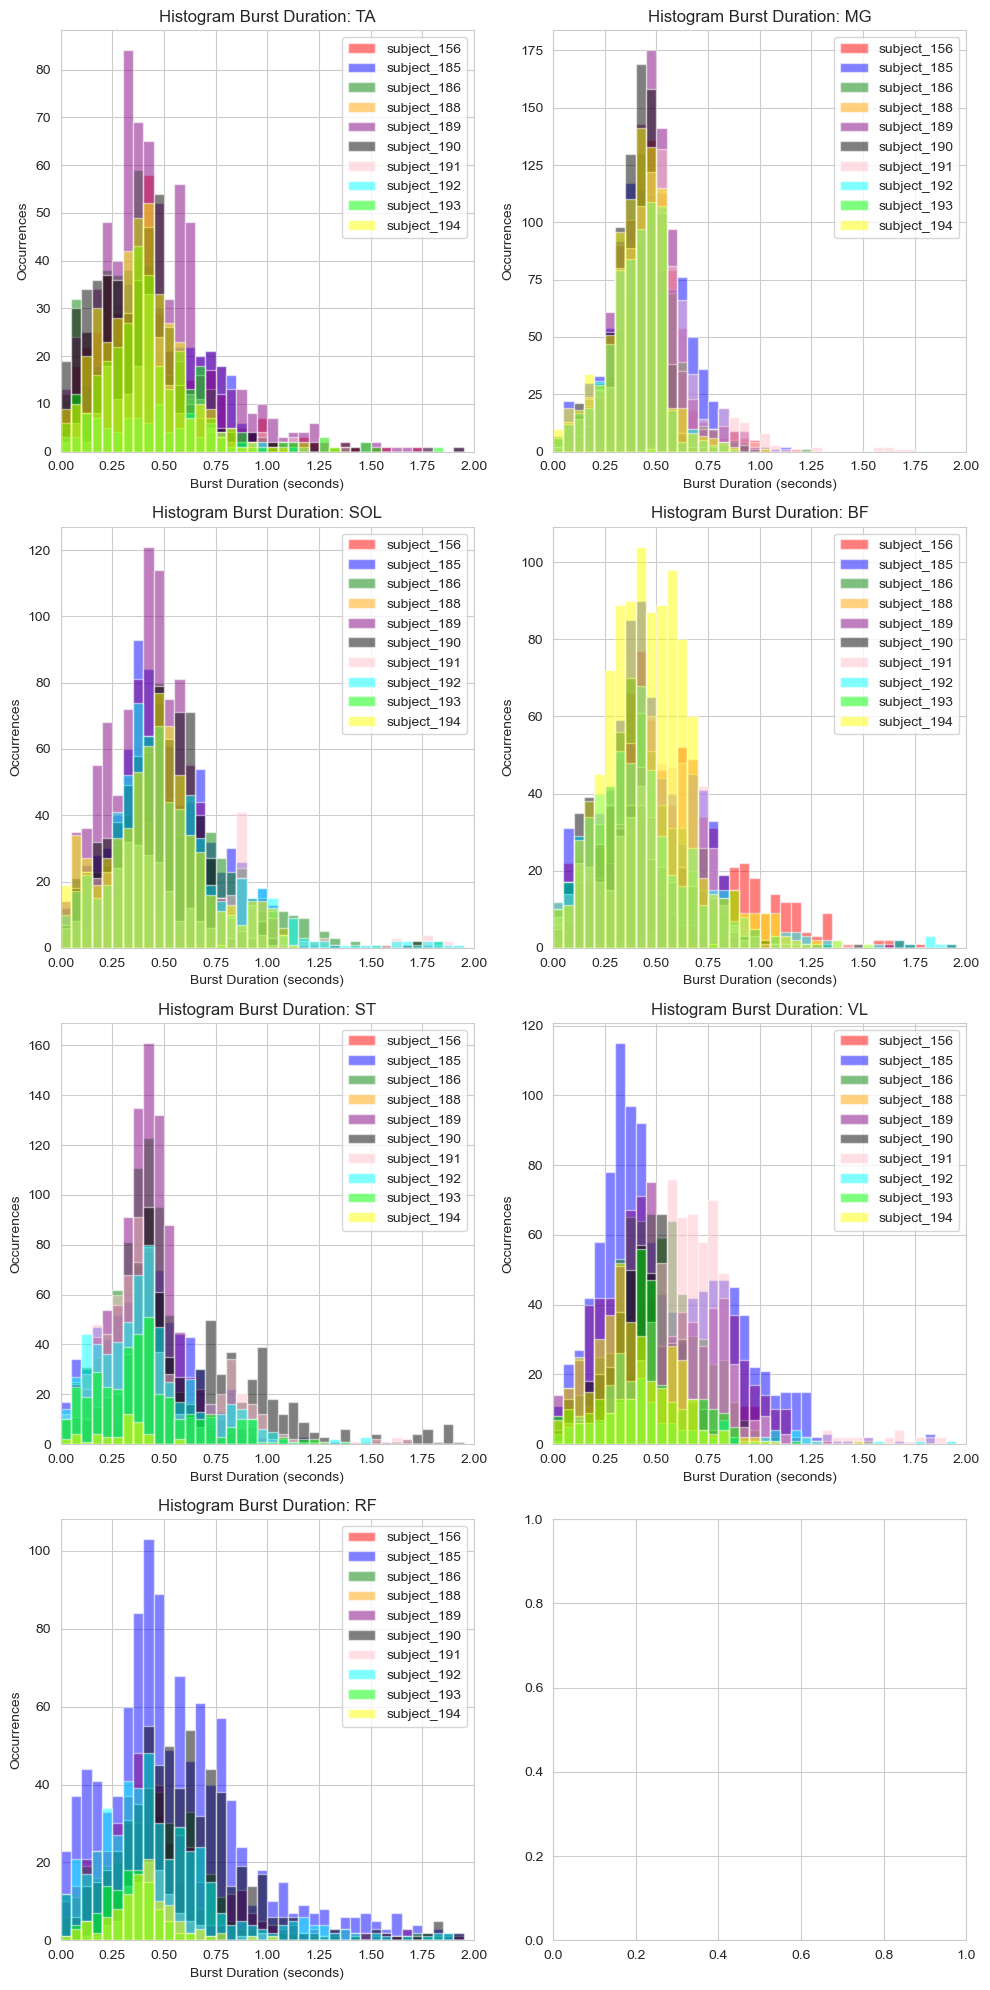

In [24]:
# Adjust subplot indexing
f, a = plt.subplots(4, 2)
f.set_size_inches(10, 20)
a = a.ravel()
bin_edges = np.arange(start=0, stop=2, step=0.05)  # Example for bins of width 0.05
colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan', 'lime', 'yellow']

for subject_idx, subject in enumerate(subjects):
	subject = "subject_" + subject
	a[0].hist(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[1].hist(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[2].hist(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0]),bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[3].hist(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[4].hist(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[5].hist(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
	a[6].hist(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])

# Set legends, titles, and labels for each subplot
for muscle_idx, muscle in enumerate(muscles):
	a[muscle_idx].legend(loc='upper right')
	a[muscle_idx].set_title('Histogram Burst Duration: ' + muscle)
	a[muscle_idx].set_xlabel("Burst Duration (seconds)")
	a[muscle_idx].set_ylabel("Occurrences")
	a[muscle_idx].set_xlim([0, 2])  # Remove to see how bad the burst detection is 

plt.tight_layout()
plt.show()

# Extracting Bursts

### Method: Preserving Onset and Window = 300ms

In [25]:
def extract_burst_windows(muscle_emg_signal, onset_list, window_size, left_shift_value, muscle_name):
	sampling_rate = 1000
	all_subjects_burst_samples = []
	for subject_index in tqdm(range(len(onset_list)), desc=f"Extracting Bursts for {muscle_name}"):
		current_subject_bursts = []
		ii = -1
		for onset in onset_list[subject_index][0]:
			ii += 1
			onset_ms = int(onset * sampling_rate) - left_shift_value
			current_sample_window = []
			if onset != onset_list[subject_index][0][-1]:
				if (onset_ms + window_size) < (onset_list[subject_index][0][ii + 1] * 1000):
					for time_step in range(window_size):
						current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
			else:
				for time_step in range(window_size):
					current_sample_window.append(muscle_emg_signal[onset_ms + time_step])

			if current_sample_window:
				current_sample_window -= np.mean(current_sample_window)
				current_subject_bursts.append(current_sample_window)
		all_subjects_burst_samples.append(current_subject_bursts)
	return all_subjects_burst_samples

In [26]:
window = 300 # in ms (total window size)
left_shift = 100 # in ms (left shift from detected onset). See detected onset on the vertical red lines in the plots above

fixed_bursts_TA = extract_burst_windows(df_all_subjects['TA'], detected_bursts_TA, window, left_shift, 'TA')
fixed_bursts_MG = extract_burst_windows(df_all_subjects['MG'], detected_bursts_MG, window, left_shift, 'MG')
fixed_bursts_SOL= extract_burst_windows(df_all_subjects['SOL'],detected_bursts_SOL,window, left_shift, 'SOL')
fixed_bursts_BF = extract_burst_windows(df_all_subjects['BF'], detected_bursts_BF, window, left_shift, 'BF')
fixed_bursts_ST = extract_burst_windows(df_all_subjects['ST'], detected_bursts_ST, window, left_shift, 'ST')
fixed_bursts_VL = extract_burst_windows(df_all_subjects['VL'], detected_bursts_VL, window, left_shift, 'VL')
fixed_bursts_RF = extract_burst_windows(df_all_subjects['RF'], detected_bursts_RF, window, left_shift, 'RF')

Extracting Bursts for TA:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for MG:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for SOL:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for BF:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for ST:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for VL:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for RF:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
# Defining Variables to store the total number of bursts for every muscle 
tot_bursts_TA = []; tot_bursts_MG = []; tot_bursts_SOL= []; tot_bursts_BF = []
tot_bursts_ST = []; tot_bursts_VL = []; tot_bursts_RF = []
burst_count_list_for_printing = []

# Calculating the total number of bursts per muscle
for subject_idx, subject in enumerate(subjects):
	tot_bursts_TA.append(len(fixed_bursts_TA[subject_idx]))
	tot_bursts_MG.append(len(fixed_bursts_MG[subject_idx]))
	tot_bursts_SOL.append(len(fixed_bursts_SOL[subject_idx]))
	tot_bursts_BF.append(len(fixed_bursts_BF[subject_idx]))
	tot_bursts_ST.append(len(fixed_bursts_ST[subject_idx]))
	tot_bursts_VL.append(len(fixed_bursts_VL[subject_idx]))
	tot_bursts_RF.append(len(fixed_bursts_RF[subject_idx]))
	# Saving the results in a list for fancy printing
	burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
	                                      tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
	                                      tot_bursts_RF[subject_idx]])

# Adding the total row to the printing
burst_count_list_for_printing.append([])
burst_count_list_for_printing.append(['---'])
burst_count_list_for_printing.append(['Total Sum', sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF), sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF)])

# Printing the table
print("Number of Muscle Bursts Per Subject Per Muscle:\n")
headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts"]
print(tabulate(burst_count_list_for_printing, headers=headers))

Number of Muscle Bursts Per Subject Per Muscle:

Subject      TA Bursts    MG Bursts    SOL Bursts    BF Bursts    ST Bursts    VL Bursts    RF Bursts
---------  -----------  -----------  ------------  -----------  -----------  -----------  -----------
156                449          760           296          813           40          214          156
185                399          946           824          736          730         1125         1100
186                395          727           690          552          736          644          472
188                 16           31           166           15            5           84            3
189                713          973           998          300          946          790          466
190                445          851           737          474          871          430          756
191                205          914           499          552          690          732          111
192                100          6

# TFRecords: Storing Training and Validation Datasets in Tensorflow Records

Reference: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb#scrollTo=_e3g9ExathXP

## Write TFRecords

In [28]:
def _float_feature(value):
	"""Returns a float_list from a float / double."""
	return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
	"""Returns an int64_list from a bool / enum / int / uint."""
	return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def extract_burst_windows_tfrecord(emg_series_complete, onset_lists, window_size, left_shift_value):
	# Ensure unique file names for parallel processing or repeated calls
	file_name = 'tfrecords/all_dataset.tfrecord'
	with tf.io.TFRecordWriter(file_name) as tfrecord:
		for muscle_index in tqdm(range(len(emg_series_complete)), desc="Extracting dataset to TFRecords (Fixed Window)"):
			for subject_index in range(len(onset_lists[muscle_index])):
				burst_count = 0
				ii = -1
				for onset in onset_lists[muscle_index][subject_index][0]:
					ii += 1
					onset_ms = int(onset * 1000) - left_shift_value
					current_sample_window = []
					if onset != onset_lists[muscle_index][subject_index][0][-1]:
						if (onset_ms + window_size) < (onset_lists[muscle_index][subject_index][0][ii + 1] * 1000):
							burst_count = burst_count + 1
							for time_step in range(window_size):
								current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
					else:
						burst_count = burst_count + 1
						for time_step in range(window_size):
							current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])

					if current_sample_window:
						current_sample_window -= np.mean(current_sample_window)
						# Convert your sample and label to appropriate tf.train.Feature formats
						features = {
							'label': _int64_feature(muscle_index),
							'feature': tf.train.Feature(float_list=tf.train.FloatList(value=current_sample_window)),
							'subject': _int64_feature(subject_index + 1),
							'burst': _int64_feature(burst_count)
						}
						example = tf.train.Example(features=tf.train.Features(feature=features))
						tfrecord.write(example.SerializeToString())
	return file_name

In [29]:
# .....
emg_series_tot = [df_all_subjects['TA'], df_all_subjects['MG'], df_all_subjects['SOL'],
                  df_all_subjects['BF'], df_all_subjects['ST'], df_all_subjects['VL'],
                  df_all_subjects['RF']]

detected_bursts_tot = [detected_bursts_TA, detected_bursts_MG, detected_bursts_SOL,
                       detected_bursts_BF, detected_bursts_ST, detected_bursts_VL,
                       detected_bursts_RF]
# Extracting bursts
extract_burst_windows_tfrecord(emg_series_tot, detected_bursts_tot,  window, left_shift)

Extracting dataset to TFRecords (Fixed Window):   0%|          | 0/7 [00:00<?, ?it/s]

'tfrecords/all_dataset.tfrecord'

## Read TFRecords

In [30]:
def map_fn(serialized_example):
	features = {
		'label': tf.io.FixedLenFeature([], tf.int64),
		'feature': tf.io.FixedLenFeature([window], tf.float32),
		'subject': tf.io.FixedLenFeature([], tf.int64),
		'burst':  tf.io.FixedLenFeature([], tf.int64)
	}
	example = tf.io.parse_single_example(serialized_example, features)
	return example['label'], example['feature'], example['subject'], example['burst']

In [31]:
# Iterate over the whole dataset to count records/samples (https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/)
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds:tf.data.Dataset):
	count = 0
	if tf.executing_eagerly():
		# TF v2 or v1 in eager mode
		for _ in ds:
			count = count+1
	else:
		# TF v1 in non-eager mode
		iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
		next_batch = iterator.get_next()
		with tf.compat.v1.Session() as sess:
			try:
				while True:
					sess.run(next_batch)
					count = count+1
			except tf.errors.OutOfRangeError:
				pass
	return count

In [32]:
dataset = tf.data.TFRecordDataset('tfrecords/all_dataset.tfrecord')
dataset = dataset.map(map_fn)

for label, feature, subject, burst in dataset.take(10):
	print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

label=0, Number of features=300  subject=1, burst=1
label=0, Number of features=300  subject=1, burst=2
label=0, Number of features=300  subject=1, burst=3
label=0, Number of features=300  subject=1, burst=4
label=0, Number of features=300  subject=1, burst=5
label=0, Number of features=300  subject=1, burst=6
label=0, Number of features=300  subject=1, burst=7
label=0, Number of features=300  subject=1, burst=8
label=0, Number of features=300  subject=1, burst=9
label=0, Number of features=300  subject=1, burst=10


In [33]:
def separate_dataset_per_subject_train_val(dataset, subj, train_percentage):
	# Filtering whole dataset TFRECORDS by subjects:
	dataset_subject = dataset.filter(lambda label,feature,subject,burst: subject==subj)
	# Count Total Samples for each Subject Dataset
	dataset_subject_samples = countRecords(dataset_subject)
	# Shuffling bursts per subject
	dataset_subject_shuffled = dataset_subject.shuffle(dataset_subject_samples)
	# Separating Subject Training and Evaluation Datasets:
	dataset_subject_1_train = dataset_subject_shuffled.take(int(dataset_subject_samples*train_percentage))
	dataset_subject_1_val = dataset_subject_shuffled.skip(int(dataset_subject_samples*train_percentage)).take(dataset_subject_samples - int(dataset_subject_samples*train_percentage))
	return dataset_subject_shuffled, dataset_subject_1_train, dataset_subject_1_val

In [34]:
# Training/Validation Split
train_percentage = 0.8
dataset_subject1, dataset_subject1_train, dataset_subject1_val = separate_dataset_per_subject_train_val(dataset, 1, train_percentage)
dataset_subject2, dataset_subject2_train, dataset_subject2_val = separate_dataset_per_subject_train_val(dataset, 2, train_percentage)
dataset_subject3, dataset_subject3_train, dataset_subject3_val = separate_dataset_per_subject_train_val(dataset, 3, train_percentage)
dataset_subject4, dataset_subject4_train, dataset_subject4_val = separate_dataset_per_subject_train_val(dataset, 4, train_percentage)
dataset_subject5, dataset_subject5_train, dataset_subject5_val = separate_dataset_per_subject_train_val(dataset, 5, train_percentage)
dataset_subject6, dataset_subject6_train, dataset_subject6_val = separate_dataset_per_subject_train_val(dataset, 6, train_percentage)
dataset_subject7, dataset_subject7_train, dataset_subject7_val = separate_dataset_per_subject_train_val(dataset, 7, train_percentage)
dataset_subject8, dataset_subject8_train, dataset_subject8_val = separate_dataset_per_subject_train_val(dataset, 8, train_percentage)
dataset_subject9, dataset_subject9_train, dataset_subject9_val = separate_dataset_per_subject_train_val(dataset, 9, train_percentage)
dataset_subject10,dataset_subject10_train,dataset_subject10_val= separate_dataset_per_subject_train_val(dataset, 10,train_percentage)

for label, feature, subject, burst in dataset_subject1_train.take(10):
	print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

label=3, Number of features=300  subject=1, burst=73
label=3, Number of features=300  subject=1, burst=477
label=1, Number of features=300  subject=1, burst=722
label=3, Number of features=300  subject=1, burst=313
label=0, Number of features=300  subject=1, burst=275
label=2, Number of features=300  subject=1, burst=217
label=1, Number of features=300  subject=1, burst=130
label=1, Number of features=300  subject=1, burst=3
label=3, Number of features=300  subject=1, burst=280
label=3, Number of features=300  subject=1, burst=341


In [35]:
# ???????
all_subject_datasets_train = [dataset_subject1_train, dataset_subject2_train, dataset_subject3_train,
                              dataset_subject4_train, dataset_subject5_train, dataset_subject6_train,
                              dataset_subject7_train, dataset_subject8_train, dataset_subject9_train,
                              dataset_subject10_train]

all_subject_datasets_val =   [dataset_subject1_val, dataset_subject2_val, dataset_subject3_val,
                              dataset_subject4_val, dataset_subject5_val, dataset_subject6_val,
                              dataset_subject7_val, dataset_subject8_val, dataset_subject9_val,
                              dataset_subject10_val]

In [36]:
# ????????????
def augment_datasets(collection_datasets, tf_record_name):
    with tf.io.TFRecordWriter(tf_record_name) as tfrecord:
        # Check if the input is not a list (assuming a single dataset tuple)
        if not isinstance(collection_datasets, list):
            collection_datasets = [collection_datasets]  # Wrap it in a list if it's a single dataset

        for dataset in collection_datasets:
            for label, feature, subject, burst in dataset:
                features = {
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([label]))),
                    'feature': tf.train.Feature(float_list=tf.train.FloatList(value=np.asarray(feature))),
                    'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([subject]))),
                    'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([burst])))
                }
                example = tf.train.Example(features=tf.train.Features(feature=features))
                tfrecord.write(example.SerializeToString())

# # ????
# def augment_datasets(collection_datasets, tf_record_name, is_list_of_datasets=False):
#     with tf.io.TFRecordWriter(tf_record_name) as tfrecord:
#         # If it's a single dataset, wrap it in a list to uniform the handling.
#         if not is_list_of_datasets:
#             collection_datasets = [collection_datasets]
# 
#         for dataset in collection_datasets:
#             for label, feature, subject, burst in dataset:
#                 features = {
#                     'label': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([label]))),
#                     'feature': tf.train.Feature(float_list=tf.train.FloatList(value=np.asarray(feature))),
#                     'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([subject]))),
#                     'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([burst])))
#                 }
#                 example = tf.train.Example(features=tf.train.Features(feature=features))
#                 tfrecord.write(example.SerializeToString())

def map_fn_final(serialized_example):
	features = {
		'label': tf.io.FixedLenFeature([], tf.int64),
		'feature': tf.io.FixedLenFeature([window], tf.float32),
		'subject': tf.io.FixedLenFeature([], tf.int64),
		'burst': tf.io.FixedLenFeature([], tf.int64)
	}
	example = tf.io.parse_single_example(serialized_example, features)
	return example['label'], example['feature'], example['subject'], example['burst']


def mix_shuffle_and_save_datasets(tf_record_read, tf_record_write):
	dataset = tf.data.TFRecordDataset(tf_record_read)
	dataset = dataset.map(map_fn_final)
	dataset_samples = countRecords(dataset)
	dataset_shuffled = dataset.shuffle(dataset_samples)

	with tf.io.TFRecordWriter(tf_record_write) as tfrecord:
		for label, feature, subject, burst in dataset_shuffled:
			features = {
				'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
				'feature': tf.train.Feature(float_list=tf.train.FloatList(value=feature.numpy())),
				'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=[subject.numpy()])),
				'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=[burst.numpy()]))
			}
			example = tf.train.Example(features=tf.train.Features(feature=features))
			tfrecord.write(example.SerializeToString())

In [37]:
# Augment datasets 
pbar = tqdm(total=len(list_of_all_subjects_dfs)+2, desc="Datasets Augmentation Progress", unit= "Dataset")
augment_datasets(all_subject_datasets_train, 'tfrecords/augmented_train.tfrecord', is_list_of_datasets=True)
pbar.update(1)
augment_datasets(all_subject_datasets_val,   'tfrecords/augmented_val.tfrecord',   is_list_of_datasets=True)
pbar.update(1)
augment_datasets(dataset_subject1, 'tfrecords/augmented_dataset_subject_1')
pbar.update(1)
augment_datasets(dataset_subject2, 'tfrecords/augmented_dataset_subject_2')
pbar.update(1)
augment_datasets(dataset_subject3, 'tfrecords/augmented_dataset_subject_3')
pbar.update(1)
augment_datasets(dataset_subject4, 'tfrecords/augmented_dataset_subject_4')
pbar.update(1)
augment_datasets(dataset_subject5, 'tfrecords/augmented_dataset_subject_5')
pbar.update(1)
augment_datasets(dataset_subject6, 'tfrecords/augmented_dataset_subject_6')
pbar.update(1)
augment_datasets(dataset_subject7, 'tfrecords/augmented_dataset_subject_7')
pbar.update(1)
augment_datasets(dataset_subject8, 'tfrecords/augmented_dataset_subject_8')
pbar.update(1)
augment_datasets(dataset_subject9, 'tfrecords/augmented_dataset_subject_9')
pbar.update(1)
augment_datasets(dataset_subject10,'tfrecords/augmented_dataset_subject_10')
pbar.update(1)

Datasets Augmentation Progress:   0%|          | 0/12 [00:00<?, ?Dataset/s]

True

In [38]:
#Mix and shuffle then save datasets 
pbar = tqdm(total=len(list_of_all_subjects_dfs)+2, desc="Datasets \"Mix and Shuffle\" Progress", unit= "Dataset")
mix_shuffle_and_save_datasets('tfrecords/augmented_train.tfrecord', 'tfrecords/all_mixed_train.tfrecord')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_val.tfrecord', 'tfrecords/all_mixed_val.tfrecord')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_1', 'tfrecords/mixed_shuffled_subject_1')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_2', 'tfrecords/mixed_shuffled_subject_2')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_3', 'tfrecords/mixed_shuffled_subject_3')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_4', 'tfrecords/mixed_shuffled_subject_4')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_5', 'tfrecords/mixed_shuffled_subject_5')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_6', 'tfrecords/mixed_shuffled_subject_6')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_7', 'tfrecords/mixed_shuffled_subject_7')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_8', 'tfrecords/mixed_shuffled_subject_8')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_9', 'tfrecords/mixed_shuffled_subject_9')
pbar.update(1)
mix_shuffle_and_save_datasets('tfrecords/augmented_dataset_subject_10','tfrecords/mixed_shuffled_subject_10')
pbar.update(1)

Datasets "Mix and Shuffle" Progress:   0%|          | 0/12 [00:00<?, ?Dataset/s]

True

## Load TFRecords

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024

In [40]:
def read_tfrecord(serialized_example, export_subject=False):
	tfrecord_format = (
		{
			'label': tf.io.FixedLenFeature([], tf.int64),
			'feature': tf.io.FixedLenFeature([window], tf.float32),
			'subject': tf.io.FixedLenFeature([], tf.int64),
			'burst':  tf.io.FixedLenFeature([], tf.int64)
		}
	)
	example = tf.io.parse_single_example(serialized_example, tfrecord_format)
	f = tf.reshape(example['feature'], [window,1])
	f.set_shape([window, 1])
	# One-hot encode the label to match the expected shape for categorical_crossentropy
	label = tf.one_hot(example['label'], depth=7)
	if export_subject:
		return f, label, example['subject']
	return f, label

def get_dataset(tf_record_name, train_or_valid):
	# dataset = load_dataset(filename)
	dataset = tf.data.TFRecordDataset(tf_record_name)
	dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
	dataset_samples = countRecords(dataset)
	print(f"Number of {train_or_valid} Samples: ", dataset_samples)
	dataset = dataset.shuffle(dataset_samples)
	dataset = dataset.prefetch(buffer_size=AUTOTUNE)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset

In [41]:
train_dataset = get_dataset('tfrecords/all_mixed_train.tfrecord', 'Train')
valid_dataset = get_dataset('tfrecords/all_mixed_val.tfrecord', 'Validation')

all_subjects_loo_data = [get_dataset(f'tfrecords/mixed_shuffled_subject{i}', f"Subject_{i}") for i in range(1, 11)]

Number of Train Samples:  27596
Number of Validation Samples:  6904
Number of Subject_1 Samples:  2728
Number of Subject_2 Samples:  5860
Number of Subject_3 Samples:  4216
Number of Subject_4 Samples:  320
Number of Subject_5 Samples:  5186
Number of Subject_6 Samples:  4564
Number of Subject_7 Samples:  3703
Number of Subject_8 Samples:  3456
Number of Subject_9 Samples:  1083
Number of Subject_10 Samples:  3384


## Verifying the shapes of: LOO, Training and Validation

In [42]:
for feature, label in train_dataset:
	print(f'Train: label={label.shape}, feature={feature.shape}')

Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=

In [43]:
for feature, label in valid_dataset:
	print(f'Validation: label={label.shape}, feature={feature.shape}')

Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(760, 7), feature=(760, 300, 1)


In [ ]:
print("Subject Summaries:")
print("------------------------------------------------")
for subj_idx, subj in enumerate(all_subjects_loo_data):
    print(f"Subject {subj_idx+1}:")
    unique_labels = set()
    min_feature_shape = ()
    max_feature_shape = (0, 0, 0)
    
    for feature, label in subj:
        unique_labels.add(label.shape)
        min_feature_shape = min(min_feature_shape, feature.shape) if min_feature_shape else feature.shape
        max_feature_shape = max(max_feature_shape, feature.shape)

    print(f"  Unique Label Shapes: {unique_labels}")
    print(f"  Feature Shape Range: {min_feature_shape} to {max_feature_shape}")
    print("####")

In [47]:
for subj_idx, subj in enumerate(all_subjects_loo_data):	
	for feature, label in subj:
		print(f'Subject_{subj_idx+1}: label={label.shape}, feature={feature.shape}')
	print("####")

Subject_1: label=(1024, 7), feature=(1024, 300, 1)
Subject_1: label=(1024, 7), feature=(1024, 300, 1)
Subject_1: label=(680, 7), feature=(680, 300, 1)
####
Subject_2: label=(1024, 7), feature=(1024, 300, 1)
Subject_2: label=(1024, 7), feature=(1024, 300, 1)
Subject_2: label=(1024, 7), feature=(1024, 300, 1)
Subject_2: label=(1024, 7), feature=(1024, 300, 1)
Subject_2: label=(1024, 7), feature=(1024, 300, 1)
Subject_2: label=(740, 7), feature=(740, 300, 1)
####
Subject_3: label=(1024, 7), feature=(1024, 300, 1)
Subject_3: label=(1024, 7), feature=(1024, 300, 1)
Subject_3: label=(1024, 7), feature=(1024, 300, 1)
Subject_3: label=(1024, 7), feature=(1024, 300, 1)
Subject_3: label=(120, 7), feature=(120, 300, 1)
####
Subject_4: label=(320, 7), feature=(320, 300, 1)
####
Subject_5: label=(1024, 7), feature=(1024, 300, 1)
Subject_5: label=(1024, 7), feature=(1024, 300, 1)
Subject_5: label=(1024, 7), feature=(1024, 300, 1)
Subject_5: label=(1024, 7), feature=(1024, 300, 1)
Subject_5: label=(1

## Plotting Muscle Bursts Samples

In [48]:
# # quick plot to see individual contraction bursts
# def plot_independent_bursts(label, burst_list, color):
#     n_cols = len(burst_list)  # number of subjects
#     fig, axs = plt.subplots(1, n_cols, figsize=(15, 3), dpi=150)  # Adjusted figure size
#     fig.subplots_adjust(top=0.85)  # Adjust top spacing
#     fig.suptitle(f'Contraction Bursts: {label} (300ms Fixed Length)', y=0.95)  # Adjust title position
# 
#     for j in range(n_cols):
#         axs[j].plot(burst_list[j][0], color=color)  # Assuming you want the first burst
#         axs[j].set_title(f'1st Burst of subject {j+1}', fontsize=10)
#         axs[j].set_xlabel('time (ms)', fontsize=8)
#         axs[j].set_ylabel('EMG', fontsize=8)
#         axs[j].label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots.
# 
#     plt.tight_layout(pad=2.0, w_pad=0.5)  # Dynamically adjust layout
#     plt.show()
# 
# plot_independent_bursts("TA", fixed_bursts_TA, "cornflowerblue")
# plot_independent_bursts("MG", fixed_bursts_MG, "orange")
# plot_independent_bursts("SOL",fixed_bursts_SOL,"red")
# plot_independent_bursts("BF", fixed_bursts_BF, "green")
# plot_independent_bursts("ST", fixed_bursts_ST, "orange")
# plot_independent_bursts("VL", fixed_bursts_VL, "cyan")
# plot_independent_bursts("RF", fixed_bursts_RF, "brown")

# Hybrid CNN-LSTM Model Implementation

In [49]:
# Parameters
# epochs = 300 # For full performance test, seems okay 
# epochs = 150 # For quick performance testing


epochs = 5 # DELETE AFTER TESTING THE LOSOCV LOOP !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



lr = 0.01
scheduler = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0001)  # Adjust patience as needed!!!!!!!

## CNN Layer 1
conv1D_1 = [32,5,1]  # number_filters,kernel_size and strides 
# conv1D_1 = [64,3,1]  # number_filters,kernel_size and strides 
dropout_1= 0.3      # Dropout %
pool1D_1 = [2,2]     # pool_size and strides

## CNN Layer 2
conv1D_2 = [64,7,1]  # number_filters,kernel_size and strides
# conv1D_2 = [96,5,1]  # number_filters,kernel_size and strides
dropout_2= 0.3      # Dropout %
pool1D_2 = [2,2]     # pool_size and strides

#     ## CNN Layer 3
conv1D_3 = [128,9,1] # number_filters,kernel_size and strides
# conv1D_3 = [256,7,1] # number_filters,kernel_size and strides
dropout_3= 0.3      # Dropout %
pool1D_3 = [2,2]     # pool_size and strides

# Dense 1
dense_1  = 50        # nodes ->50
dense_dropout_1 = 0.3# Dropout %
# Dense 2
dense_2 = 0          # nodes ->0
# LSTM 1             
lstm_1   = 30        # lstm blocks ->30
lstm_dropout_1 = 0.3 # Dropout %
# Dense 3
dense_3  = 15        # nodes ->15
dense_dropout_3 = 0.3# Dropout %

# Definition
model1 = Sequential()
model1.add(InputLayer((window,1))) #InputLayer(BURST_WINDOW, N_CHANNELS)

# CNN LAYER 1 (Conv1D + PReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_1[0],kernel_size=conv1D_1[1], strides=conv1D_1[2],padding='same', name='cnn_layer_1')) # TODO TRY WITH HIGHER KERNEL SIZE (ODD NUMBER!)
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(MaxPooling1D(pool_size=pool1D_1[0], strides=pool1D_1[1], padding='same'))
model1.add(Dropout(dropout_1))

# CNN LAYER 2 (Conv1D + PReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_2[0], kernel_size=conv1D_2[1], strides=conv1D_2[2], padding='same', name='cnn_layer_2'))
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(MaxPooling1D(pool_size=pool1D_2[0], strides=pool1D_2[1], padding='same'))
model1.add(Dropout(dropout_2))

# CNN LAYER 3 (Conv1D + LeakyReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_3[0], kernel_size=conv1D_3[1], strides=conv1D_3[2], padding='same', name='cnn_layer_3'))
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(MaxPooling1D(pool_size=pool1D_3[0], strides=pool1D_3[1], padding='same'))
model1.add(Dropout(dropout_3))

# Global Average Pooling
model1.add(GlobalAveragePooling1D())

# Dense 1:  To integrate the Dense Layer 1 effectively after GAP, we reshape the output to make it compatible with the dense layer expectations
model1.add(Reshape((1, -1)))
model1.add(Dense(dense_1))
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(Dropout(dense_dropout_1))

# LSTM LAYER 1 + Dropout
model1.add(LSTM(lstm_1, dropout=lstm_dropout_1))

# Dense 3
model1.add(Dense(dense_3))
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(Dropout(dense_dropout_3))

# Softmax
model1.add(Dense(7, 'softmax')) # Softmax

#Summary
model1.summary()

# Loading Pretrained Weights
# model1.load_weights('w_cnn1.h5', by_name=True, skip_mismatch=False, options=None)
# model1.load_weights('w_cnn2.h5', by_name=True, skip_mismatch=False, options=None)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_layer_1 (Conv1D)            │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_2 (Conv1D)            │ (None, 150, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_3 (Conv1D)            │ (None, 75, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 50)          │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,195 (410.92 KB)

 Trainable params: 105,195 (410.92 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Starting the wandb logging & Parameters
config = {
	"number of muscles": len(muscles),
	"number of subjects": len(list_of_all_subjects_dfs)+1,
	"LOSOCV": "On",
	"batch_size": BATCH_SIZE,
	"learning_rate":lr,
	"epochs": epochs,
	"scheduler": "ReduceLROnPlateau",
	"optimizer": "Adam",
	"GAP": "On",

	"CNN_1": conv1D_1,
	"CNN_1_Activation": "LeakyReLU",
	"CNN_1_Pool": pool1D_1,
	"CNN_1_dropout": dropout_1,

	"CNN_2": conv1D_2,
	"CNN_2_Activation": "LeakyReLU",
	"CNN_2_Pool": pool1D_2,
	"CNN_2_dropout": dropout_2,

	"CNN_3": conv1D_3,
	"CNN_3_Activation": "LeakyReLU",
	"CNN_3_Pool": pool1D_3,
	"CNN_3_dropout": dropout_3,

	"dense_1": dense_1,
	"dense_1_dropout": dense_dropout_1,

	"lstm_1": lstm_1,
	"lstm_1_dropout": lstm_dropout_1,

	"dense_3": dense_3,
	"dense_3_dropout": dense_dropout_3}

wandb.init(project='Thesis', entity='firass-koli', config=config)

optimizer = Adam(learning_rate=wandb.config.learning_rate)

wandb: Currently logged in as: firass-koli. Use `wandb login --relogin` to force relogin


In [51]:
def clear_and_create_directory(directory):
	"""Check if a directory exists and clear it, then recreate it."""
	if os.path.exists(directory):
		# Remove the directory and all its contents
		shutil.rmtree(directory)
		print(f"Old \"{directory}\" directory of the previous model deleted!")
	# Create the directory again
	os.makedirs(directory, exist_ok=True)

In [52]:
# Deleting the old directories of the previously trained models
clear_and_create_directory("model1")
clear_and_create_directory("histories")
clear_and_create_directory("results")

Old "model1" directory of the previous model deleted!
Old "histories" directory of the previous model deleted!
Old "results" directory of the previous model deleted!


In [53]:
model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])  # TODO: Try DK (Learning rate)
cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [54]:
# with tf.device('/gpu:0'):
# Training the model with the wandb callback
history = model1.fit( train_dataset, validation_data=valid_dataset, epochs=wandb.config.epochs,
                      callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

# Log the best validation accuracy and loss
wandb.log({"best_val_accuracy": max(history.history['val_accuracy']), "min_val_loss": min(history.history['val_loss'])})

Epoch 1/5


wandb: ERROR Unable to log learning rate.


     27/Unknown 26s 369ms/step - accuracy: 0.1839 - loss: 1.9245

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.1841 - loss: 1.9214 - val_accuracy: 0.2173 - val_loss: 1.6235 - learning_rate: 0.0100
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 549ms/step - accuracy: 0.2012 - loss: 1.8601 - val_accuracy: 0.2050 - val_loss: 1.6015 - learning_rate: 0.0100
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.2114 - loss: 1.8337 - val_accuracy: 0.2832 - val_loss: 1.5560 - learning_rate: 0.0100
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.2644 - loss: 1.7619 - val_accuracy: 0.3554 - val_loss: 1.3867 - learning_rate: 0.0100
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.3323 - loss: 1.6363 - val_accuracy: 0.3718 - val_loss: 1.3484 - learning_rate: 0.0100


# Useful functions for plotting loo

In [55]:
def plotting_loss_and_accuracy_over_epochs(history_namee, loo_subj_numb):
	h = np.load(history_namee+'.npy', allow_pickle=True).item()

	min_val_categ_crossentropy = round(min(h['val_loss']), 4)
	best_val_accuracy = round(max(h['val_accuracy']), 3) * 100

	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(h['val_accuracy'])

	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(f'Hybrid CNN + LSTM: Loss and Accuracy over Epochs for (Subject_{loo_subj_numb} as loo)', fontsize=18, y=0.99)
	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
	ax2.set_title(f'Accuracy (best_val_acc={best_val_accuracy}%)')
	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
	ax2.set(xlabel='Epoch', ylabel='Accuracy')
	ax1.plot(h['loss'], color="cornflowerblue", linewidth=3)
	ax1.plot(h['val_loss'], color="lightsteelblue", linewidth=3)
	ax1.legend(['Training Loss', 'Validation Loss'])
	ax2.plot(h['accuracy'], color="gold", linewidth=3)
	ax2.plot(h['val_accuracy'], color="darkorange", linewidth=3)
	ax2.legend(['Training Accuracy', 'Validation Accuracy'])

	# Add a red 'X' mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, h['val_accuracy'][best_val_acc_epoch], color='red', marker='X', s=100)

	plt.show()

In [56]:
def serializing_datasets(train_dataset_, valid_dataset_):
	X_train = [] ; y_train = []
	X_val = [] ; y_val = []

	for feature, label in train_dataset_:
		for i in range(label.shape[0]):
			X_train.append(feature[i])
			y_train.append(label[i])
	for feature, label in valid_dataset_:
		for i in range(label.shape[0]):
			X_val.append(feature[i])
			y_val.append(label[i])

	X_train = np.array(X_train) ; y_train = np.array(y_train)
	X_val = np.array(X_val) ; y_val = np.array(y_val)
	return X_train, y_train, X_val, y_val

In [57]:
def plot_confusion_matrix(x,y,color,title):
	# Find the filename of the best model saved during training
	best_model_filename = max(glob.glob('model1/best_model_epoch_*_val_acc_*.keras'), key=os.path.getctime)
	print(f"Best Model: {best_model_filename}")
	# Load the best model
	best_model = load_model(best_model_filename)

	predictions_hot = best_model.predict(x)
	predictions = np.argmax(predictions_hot, axis=1)
	np.set_printoptions(suppress=True)
	print("Some y Predicted\t", predictions[:30])
	y_list = np.argmax(y, axis=1)
	print("Some y Label\t\t", y_list[:30])

	cm = confusion_matrix(y_list, predictions)
	plt.figure(figsize = (15,10))
	ax = sn.heatmap(cm, annot=True, cmap=color, fmt='d')
	ax.set_title(title+'\n\n')
	ax.set_xlabel('Predicted Values')
	ax.set_ylabel('Actual Values ')
	ax.xaxis.set_ticklabels(['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF'])
	ax.yaxis.set_ticklabels(['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF'])

	np.set_printoptions(precision=3)
	precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
	f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average='micro')

	print(f'precision: {precision}')
	print(f'recall: {recall}')
	print(f'fscore: {f1}')
	print(f'fscore_micro: {f1_micro:.3f}')

	ax.xaxis.set_label_position('top')
	ax.xaxis.set_ticks_position('top')
	plt.show()

	return precision, recall, f1, f1_micro

In [58]:
num_subjects = len(all_subjects_loo_data)
best_loo_validation_per_subject = []
min_loo_val_loss_per_subject = []
all_interpersonal_precision = []
all_interpersonal_recall = []
all_interpersonal_f1 = []
all_interpersonal_f1_micro = []

Training with subject1 as a validation set
Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 380ms/step - accuracy: 0.2969 - loss: 1.6729 - val_accuracy: 0.7628 - val_loss: 0.6999 - learning_rate: 0.0100
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - accuracy: 0.2827 - loss: 1.6973 - val_accuracy: 0.6793 - val_loss: 0.8831 - learning_rate: 0.0100
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.2700 - loss: 1.7455 - val_accuracy: 0.7595 - val_loss: 0.7037 - learning_rate: 0.0100
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 361ms/step - accuracy: 0.2862 - loss: 1.7016 - val_accuracy: 0.6840 - val_loss: 0.6935 - learning_rate: 0.0100
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - accuracy: 0.2916 - loss: 1.6918 - val_accuracy: 0.7482 - val_loss: 0.6693 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_1 as loo: 76.3
Minimum Validation Loss for using Subject_1 as loo: 0.669


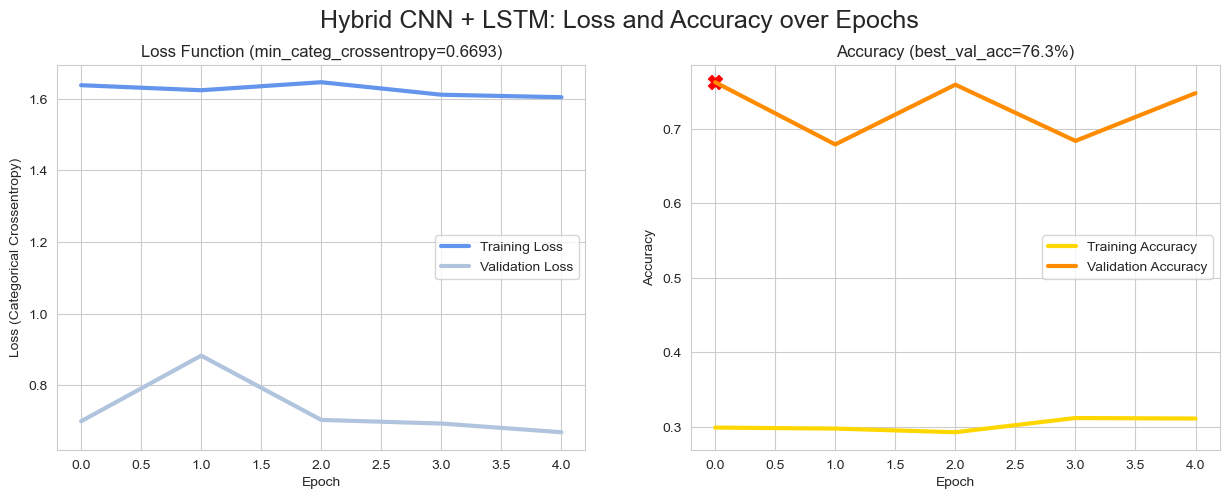

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
993/993 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [0 5 4 4 5 5 5 5 3 5 5 4 5 5 2 4 4 4 4 5 3 4 3 5 0 4 0 5 3 1]
Some y Label		 [0 5 2 3 5 6 2 2 5 5 3 6 6 5 5 4 3 6 4 5 6 2 2 6 0 2 1 1 3 1]
precision: [0.573 0.522 0.417 0.275 0.271 0.334 0.   ]
recall: [0.401 0.291 0.186 0.464 0.462 0.593 0.   ]
fscore: [0.472 0.374 0.257 0.345 0.342 0.427 0.   ]
fscore_micro: 0.345


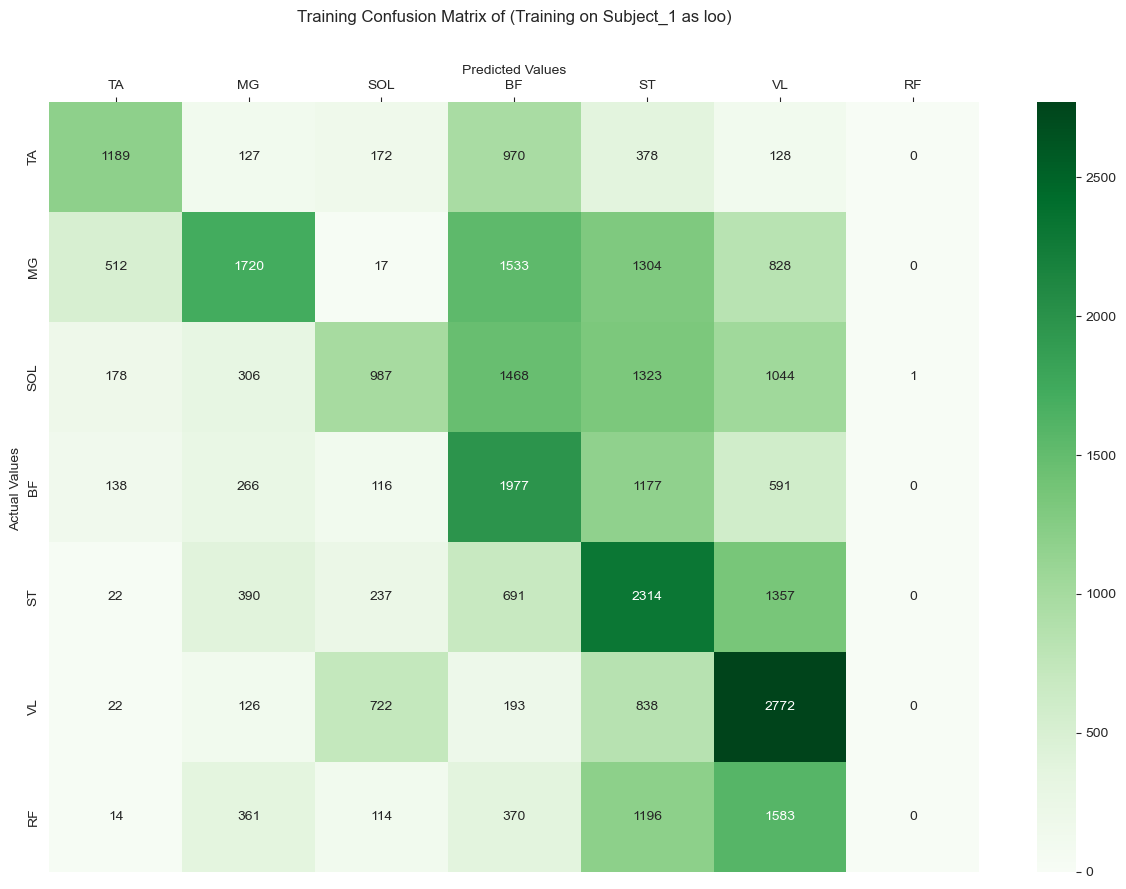

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Some y Predicted	 [3 3 1 2 0 2 1 1 3 2 3 0 2 1 2 4 0 1 2 3 0 2 2 0 0 2 2 1 0 0]
Some y Label		 [3 3 1 5 1 2 1 0 3 2 3 0 2 1 5 3 1 1 2 3 0 2 2 0 1 2 5 1 0 6]
precision: [0.574 0.992 0.402 0.99  0.    0.073 0.   ]
recall: [0.993 0.663 0.959 0.702 0.    0.042 0.   ]
fscore: [0.728 0.795 0.566 0.822 0.    0.053 0.   ]
fscore_micro: 0.665


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


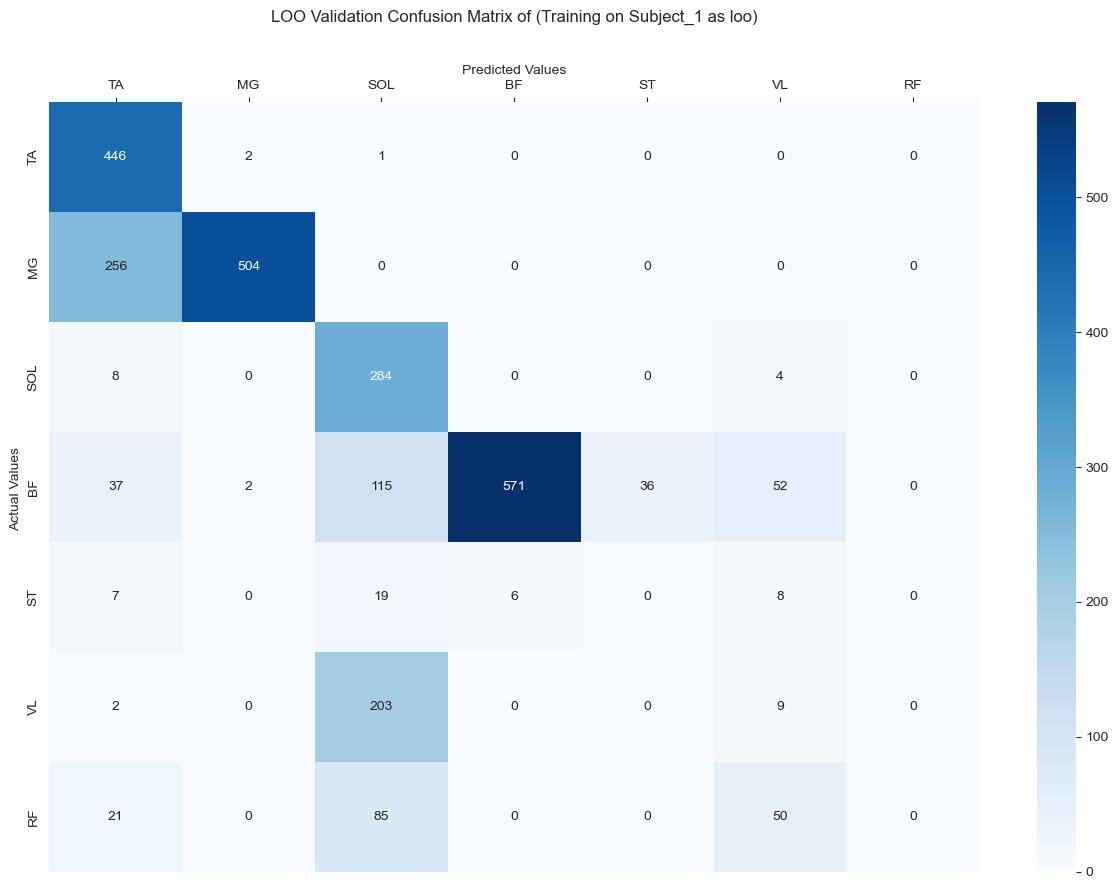

Training with subject2 as a validation set
Epoch 1/5
     34/Unknown 10s 304ms/step - accuracy: 0.4165 - loss: 1.5514

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.4146 - loss: 1.5528 - val_accuracy: 0.2427 - val_loss: 1.5698 - learning_rate: 0.0100
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.3572 - loss: 1.6014 - val_accuracy: 0.2630 - val_loss: 1.5413 - learning_rate: 0.0100
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.3732 - loss: 1.5299 - val_accuracy: 0.2776 - val_loss: 1.5056 - learning_rate: 0.0100
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 326ms/step - accuracy: 0.3863 - loss: 1.5329 - val_accuracy: 0.2759 - val_loss: 1.4456 - learning_rate: 0.0100
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step - accuracy: 0.3932 - loss: 1.4761 - val_accuracy: 0.3060 - val_loss: 1.4381 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_2 as loo: 30.599999999999998
Minimum Validation Loss for using Subject_2 as loo: 1.438


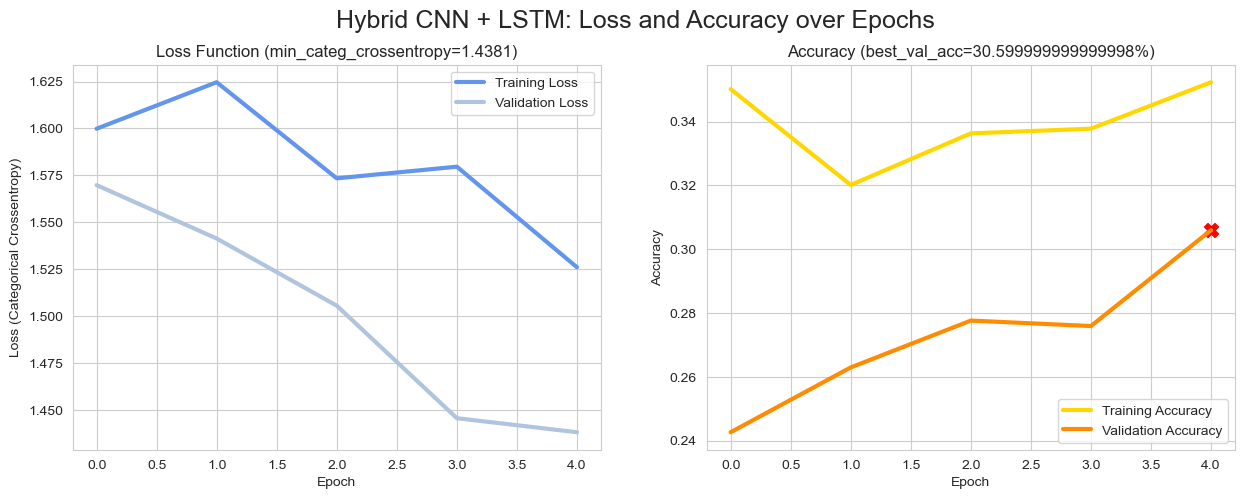

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
895/895 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Some y Predicted	 [2 2 2 2 2 1 3 0 2 2 2 3 1 5 0 2 2 0 3 1 5 0 3 0 0 0 0 0 3 3]
Some y Label		 [3 5 3 5 2 1 3 0 2 6 2 3 1 3 1 5 5 1 3 1 2 0 3 0 1 0 0 0 3 3]
precision: [0.579 0.611 0.427 0.335 0.281 0.315 0.   ]
recall: [0.49  0.343 0.237 0.509 0.45  0.56  0.   ]
fscore: [0.531 0.439 0.305 0.404 0.346 0.403 0.   ]
fscore_micro: 0.378


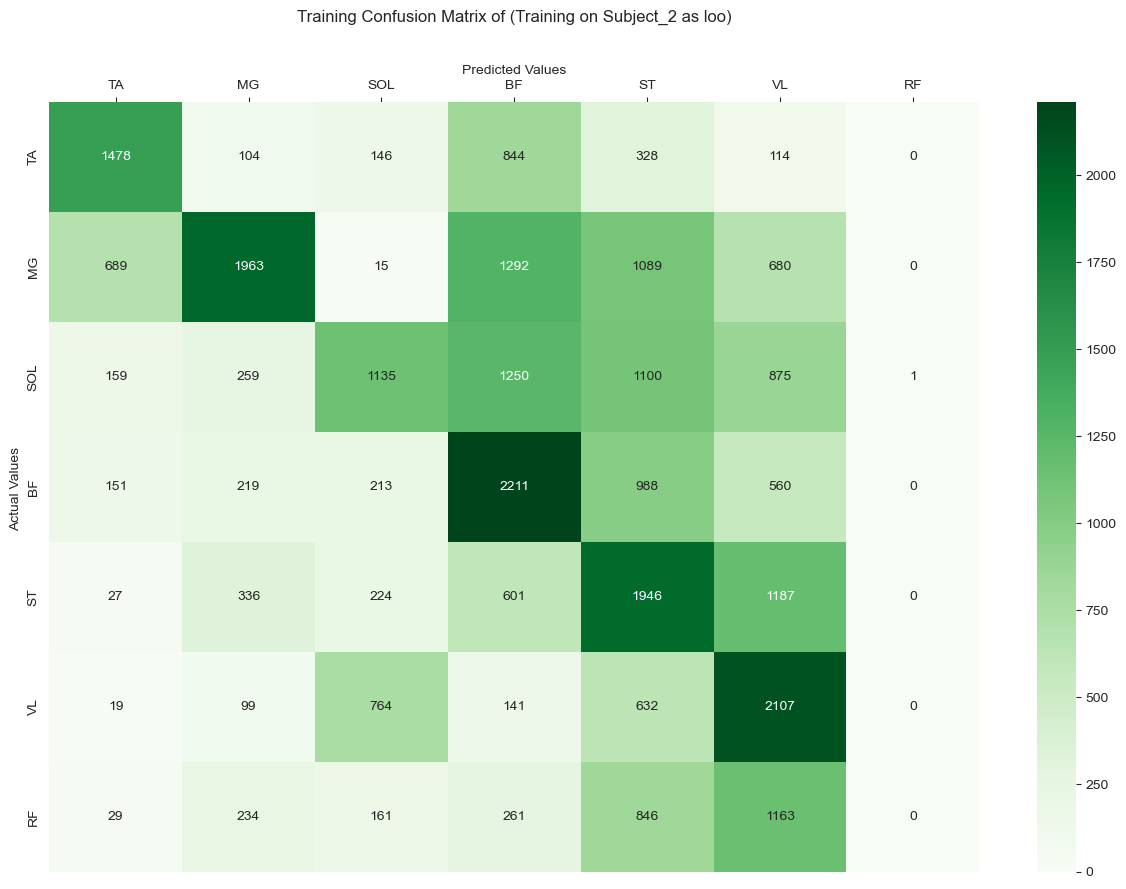

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Some y Predicted	 [0 0 3 4 2 5 5 3 4 2 3 0 1 0 3 5 1 3 4 4 4 5 3 4 4 0 5 3 1 5]
Some y Label		 [1 0 0 4 5 1 2 2 5 0 3 3 1 0 0 4 1 1 3 3 6 1 4 6 5 2 3 3 1 6]
precision: [0.523 0.442 0.329 0.286 0.225 0.387 0.   ]
recall: [0.393 0.276 0.165 0.458 0.504 0.599 0.   ]
fscore: [0.449 0.34  0.22  0.352 0.311 0.471 0.   ]
fscore_micro: 0.330


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


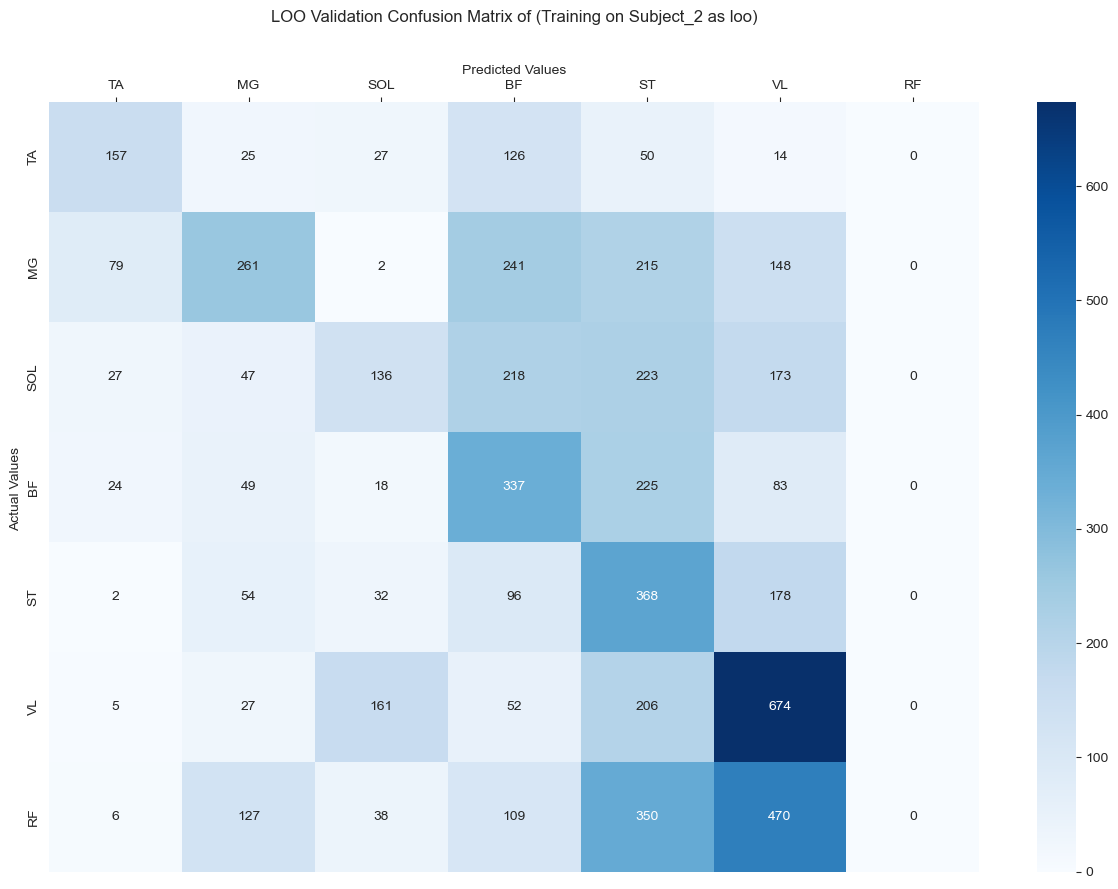

Training with subject3 as a validation set
Epoch 1/5
     35/Unknown 10s 296ms/step - accuracy: 0.3944 - loss: 1.4882

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - accuracy: 0.3934 - loss: 1.4896 - val_accuracy: 0.3624 - val_loss: 1.2866 - learning_rate: 0.0100
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.4026 - loss: 1.4476 - val_accuracy: 0.2766 - val_loss: 1.4490 - learning_rate: 0.0100
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.3916 - loss: 1.5074 - val_accuracy: 0.3086 - val_loss: 1.3680 - learning_rate: 0.0100
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.4045 - loss: 1.4758 - val_accuracy: 0.3029 - val_loss: 1.5400 - learning_rate: 0.0100
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 423ms/step - accuracy: 0.3952 - loss: 1.5197 - val_accuracy: 0.2849 - val_loss: 1.4612 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_3 as loo: 36.199999999999996
Minimum Validation Loss for using Subject_3 as loo: 1.287


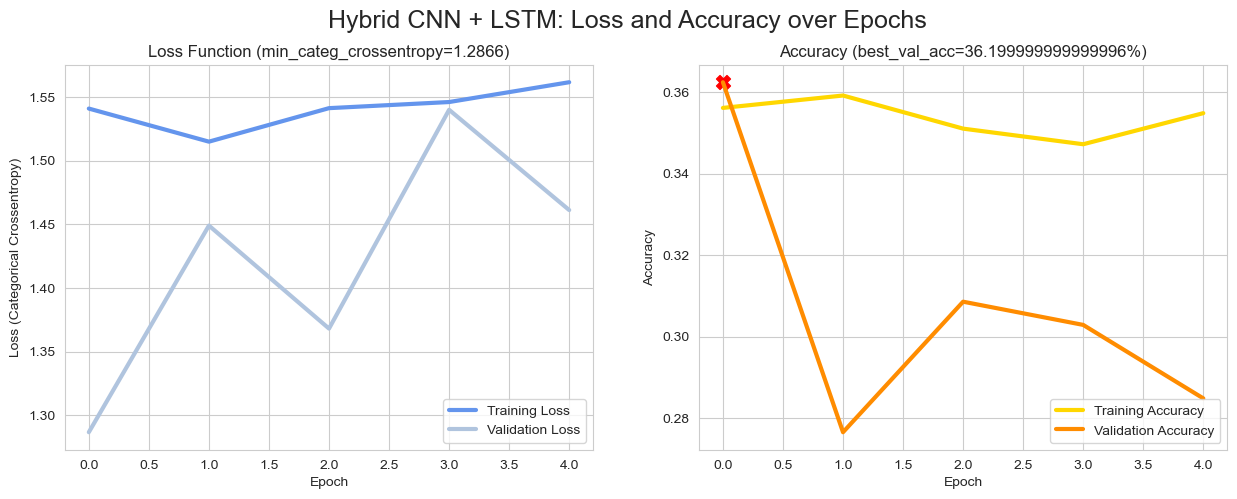

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [5 2 1 1 2 0 2 0 2 1 0 1 1 0 3 1 2 0 2 1 0 3 1 1 2 3 3 3 2 2]
Some y Label		 [3 2 1 1 5 0 2 1 6 1 0 1 1 0 3 1 3 1 3 1 0 3 1 1 2 3 3 3 2 5]
precision: [0.572 0.594 0.414 0.332 0.264 0.328 0.   ]
recall: [0.492 0.337 0.232 0.498 0.458 0.564 0.   ]
fscore: [0.529 0.43  0.297 0.398 0.335 0.415 0.   ]
fscore_micro: 0.371


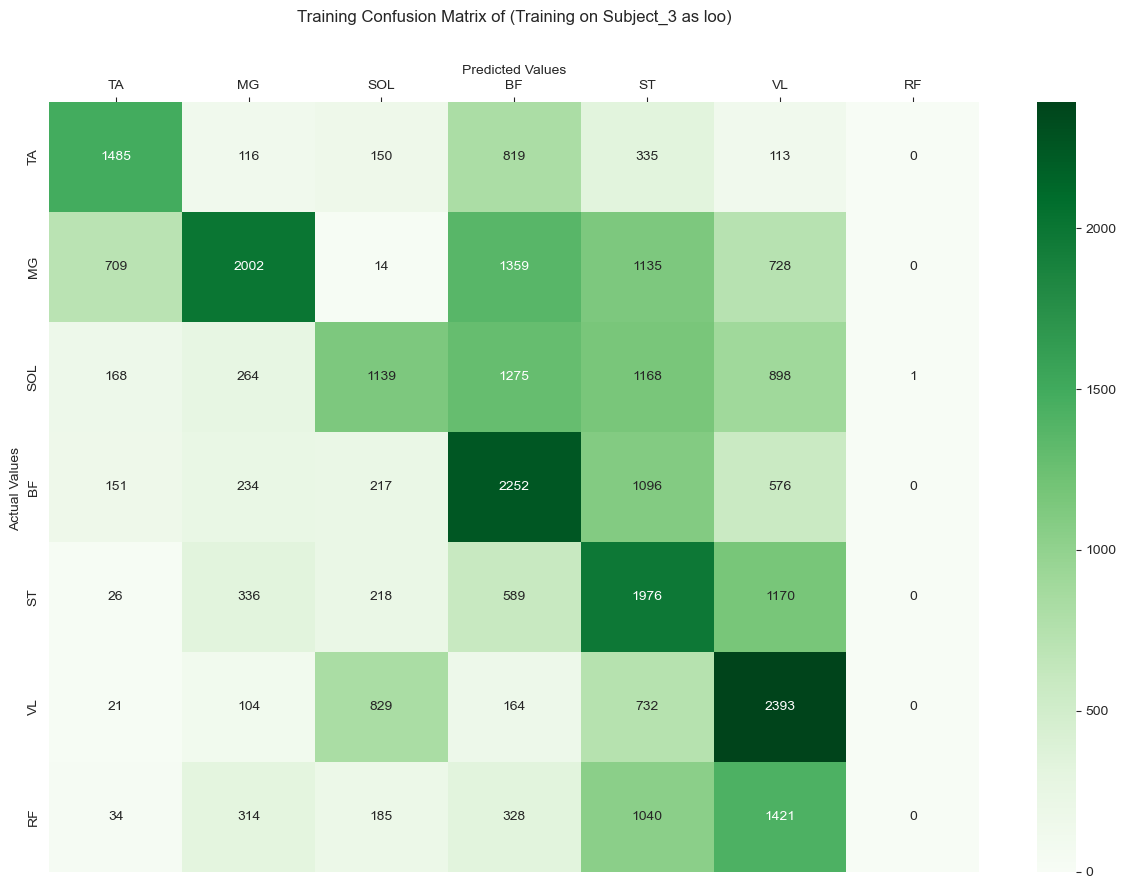

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Some y Predicted	 [3 4 1 1 4 4 4 1 5 5 5 5 0 4 4 4 4 2 3 2 4 4 5 5 4 3 5 3 3 2]
Some y Label		 [1 4 1 1 6 1 1 3 6 6 3 6 0 4 3 2 5 2 1 2 1 0 5 5 4 2 5 1 2 1]
precision: [0.581 0.512 0.412 0.298 0.312 0.344 0.   ]
recall: [0.38  0.305 0.191 0.536 0.459 0.602 0.   ]
fscore: [0.459 0.382 0.261 0.383 0.371 0.438 0.   ]
fscore_micro: 0.362


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


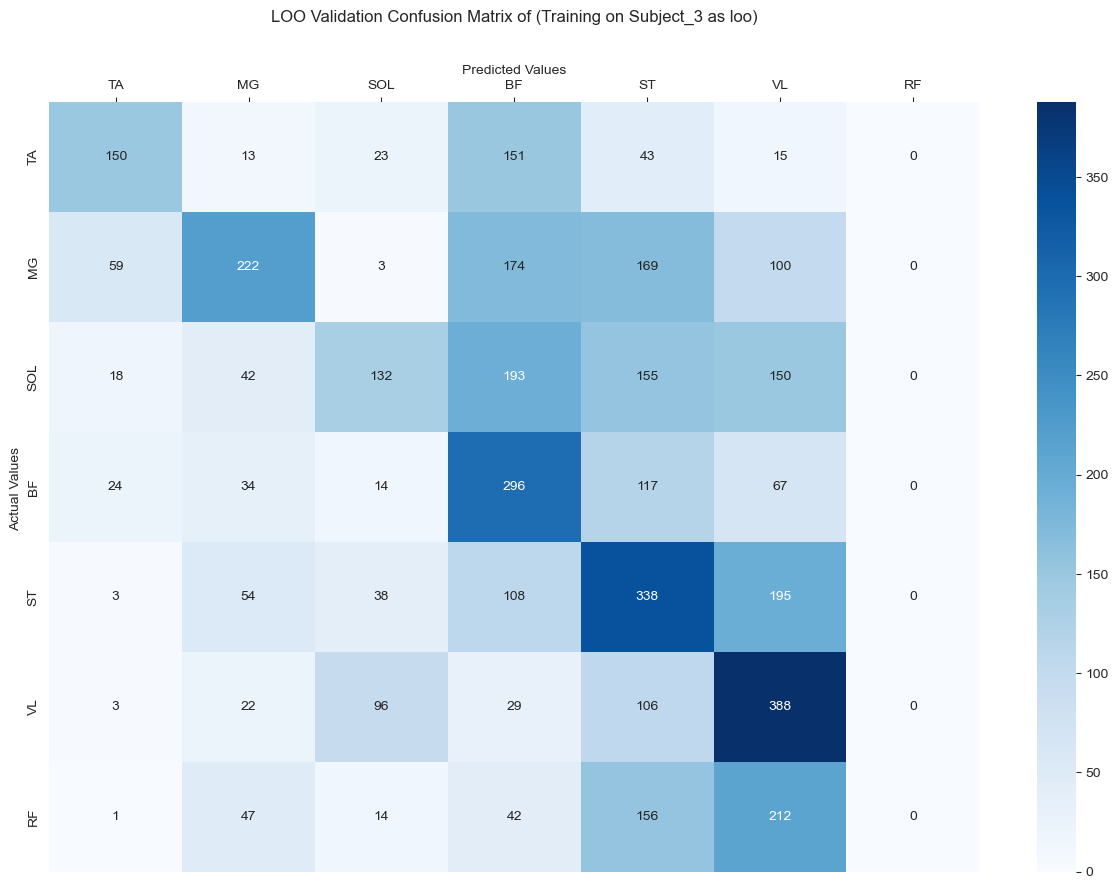

Training with subject4 as a validation set
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.3793 - loss: 1.5254 - val_accuracy: 0.2969 - val_loss: 0.7399 - learning_rate: 0.0100
Epoch 2/5


C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - accuracy: 0.3882 - loss: 1.5321 - val_accuracy: 0.2719 - val_loss: 0.7992 - learning_rate: 0.0100
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 363ms/step - accuracy: 0.3896 - loss: 1.4937 - val_accuracy: 0.3000 - val_loss: 0.7562 - learning_rate: 0.0100
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.4305 - loss: 1.4245 - val_accuracy: 0.3063 - val_loss: 0.7570 - learning_rate: 0.0100
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.4334 - loss: 1.4135 - val_accuracy: 0.2469 - val_loss: 0.8163 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_4 as loo: 30.599999999999998
Minimum Validation Loss for using Subject_4 as loo: 0.74


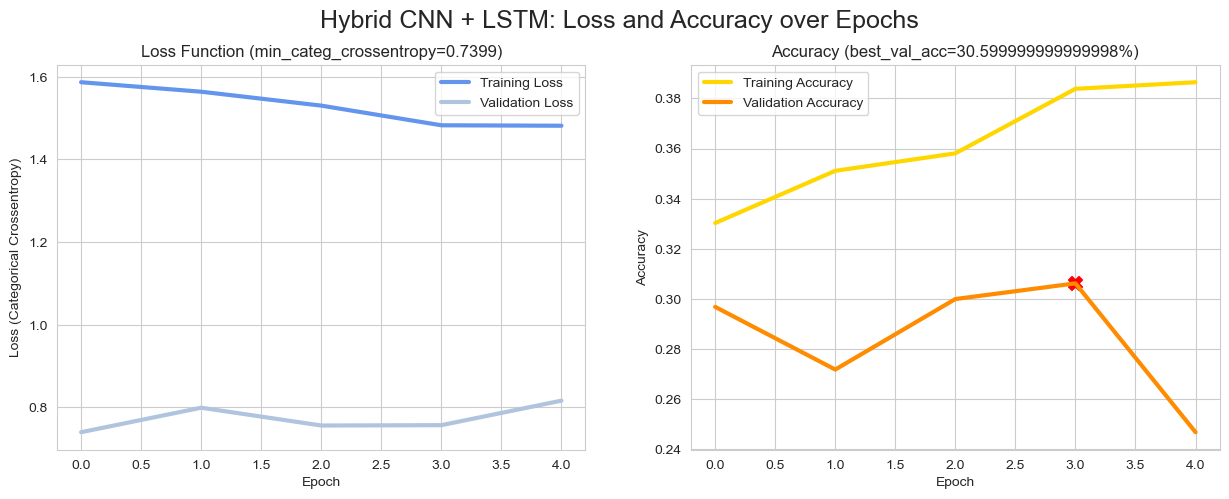

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [2 0 2 2 0 2 3 1 3 0 3 1 3 2 2 3 1 3 1 3 2 2 2 2 2 0 3 2 0 1]
Some y Label		 [2 1 5 2 0 3 3 1 3 1 3 1 3 4 6 3 1 3 1 3 5 5 2 2 5 6 3 6 0 1]
precision: [0.574 0.586 0.41  0.329 0.272 0.328 0.   ]
recall: [0.48  0.334 0.228 0.502 0.458 0.569 0.   ]
fscore: [0.522 0.425 0.293 0.398 0.342 0.416 0.   ]
fscore_micro: 0.371


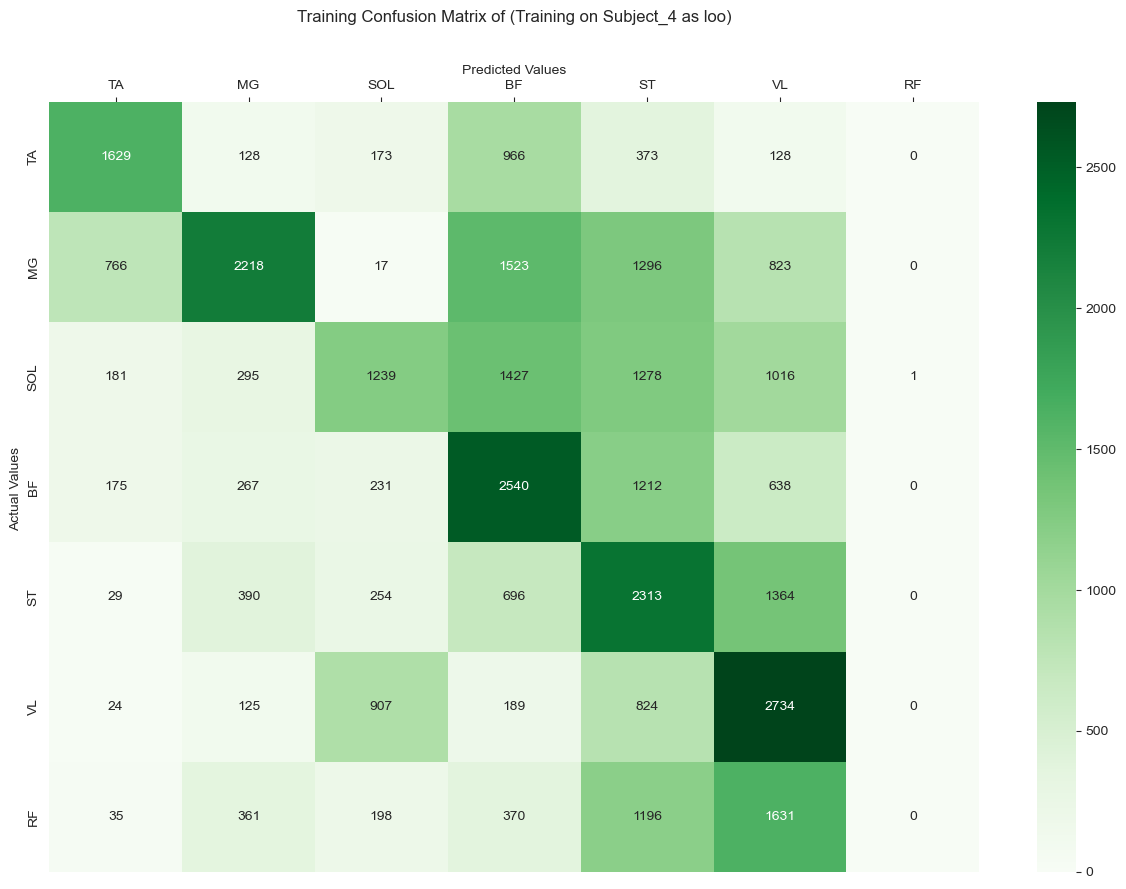

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Some y Predicted	 [3 5 5 5 4 5 3 3 5 5 3 3 4 3 3 5 5 3 5 4 2 3 4 4 3 5 3 3 2 3]
Some y Label		 [1 5 5 5 5 5 5 2 2 5 1 5 2 2 2 3 1 2 5 1 5 2 1 5 1 5 2 1 2 2]
precision: [0.462 0.3   0.604 0.118 0.014 0.511 0.   ]
recall: [0.375 0.194 0.193 0.533 0.2   0.56  0.   ]
fscore: [0.414 0.235 0.292 0.193 0.025 0.534 0.   ]
fscore_micro: 0.312


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


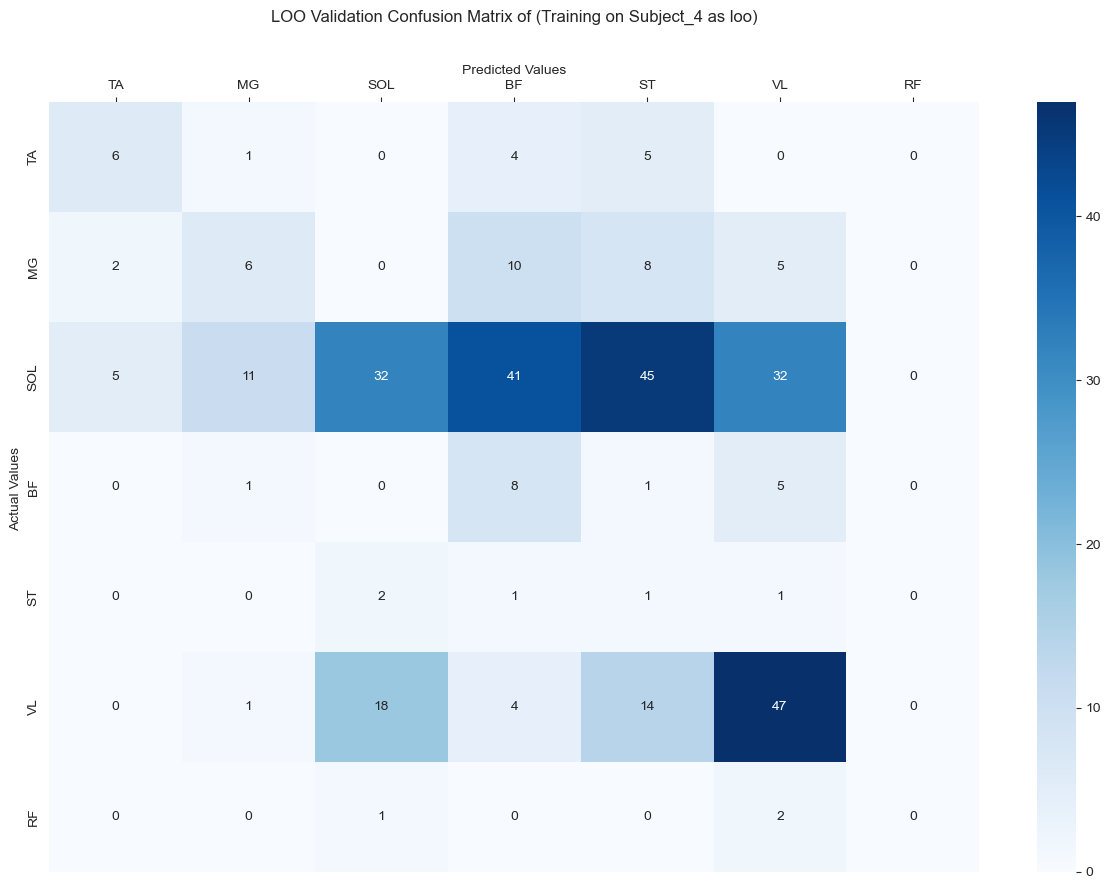

Training with subject5 as a validation set
Epoch 1/5
     34/Unknown 12s 361ms/step - accuracy: 0.4377 - loss: 1.4085

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.4360 - loss: 1.4111 - val_accuracy: 0.3752 - val_loss: 1.3172 - learning_rate: 0.0100
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 388ms/step - accuracy: 0.4068 - loss: 1.4881 - val_accuracy: 0.3708 - val_loss: 1.3203 - learning_rate: 0.0100
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.4517 - loss: 1.3811 - val_accuracy: 0.3801 - val_loss: 1.2922 - learning_rate: 0.0100
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step - accuracy: 0.4185 - loss: 1.4420 - val_accuracy: 0.3185 - val_loss: 1.3507 - learning_rate: 0.0100
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - accuracy: 0.3708 - loss: 1.5025 - val_accuracy: 0.3843 - val_loss: 1.2562 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_5 as loo: 38.4
Minimum Validation Loss for using Subject_5 as loo: 1.256


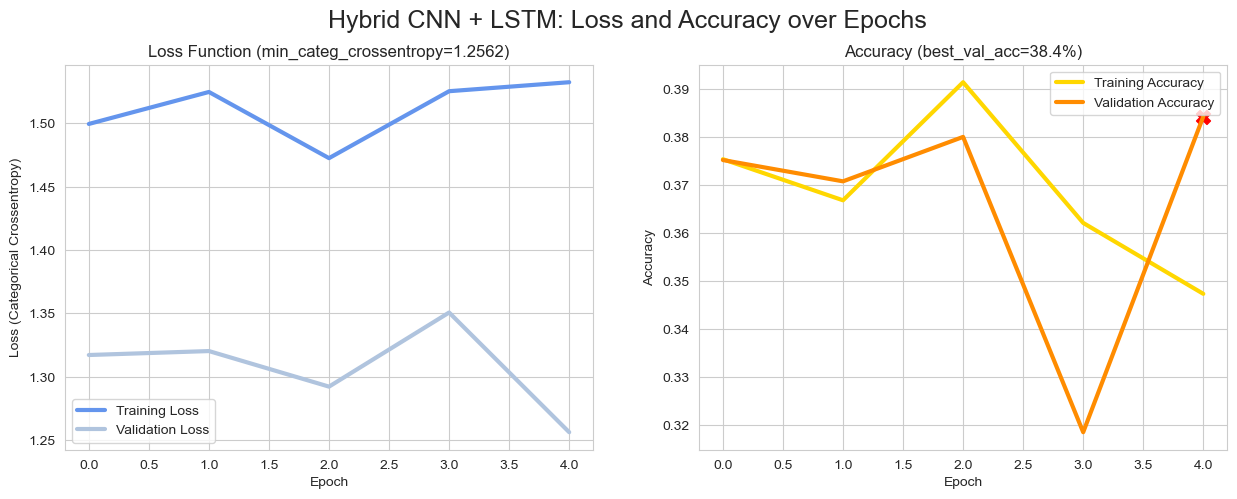

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
917/917 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
Some y Predicted	 [2 3 2 0 0 2 1 0 1 0 3 3 2 2 0 3 2 1 0 2 1 1 1 0 0 0 0 3 3 1]
Some y Label		 [6 3 6 1 1 2 1 1 1 0 3 3 2 6 0 3 5 1 0 5 1 1 1 1 0 0 2 3 3 1]
precision: [0.555 0.591 0.414 0.361 0.263 0.331 0.   ]
recall: [0.496 0.344 0.237 0.505 0.46  0.57  0.   ]
fscore: [0.524 0.435 0.301 0.421 0.334 0.419 0.   ]
fscore_micro: 0.376


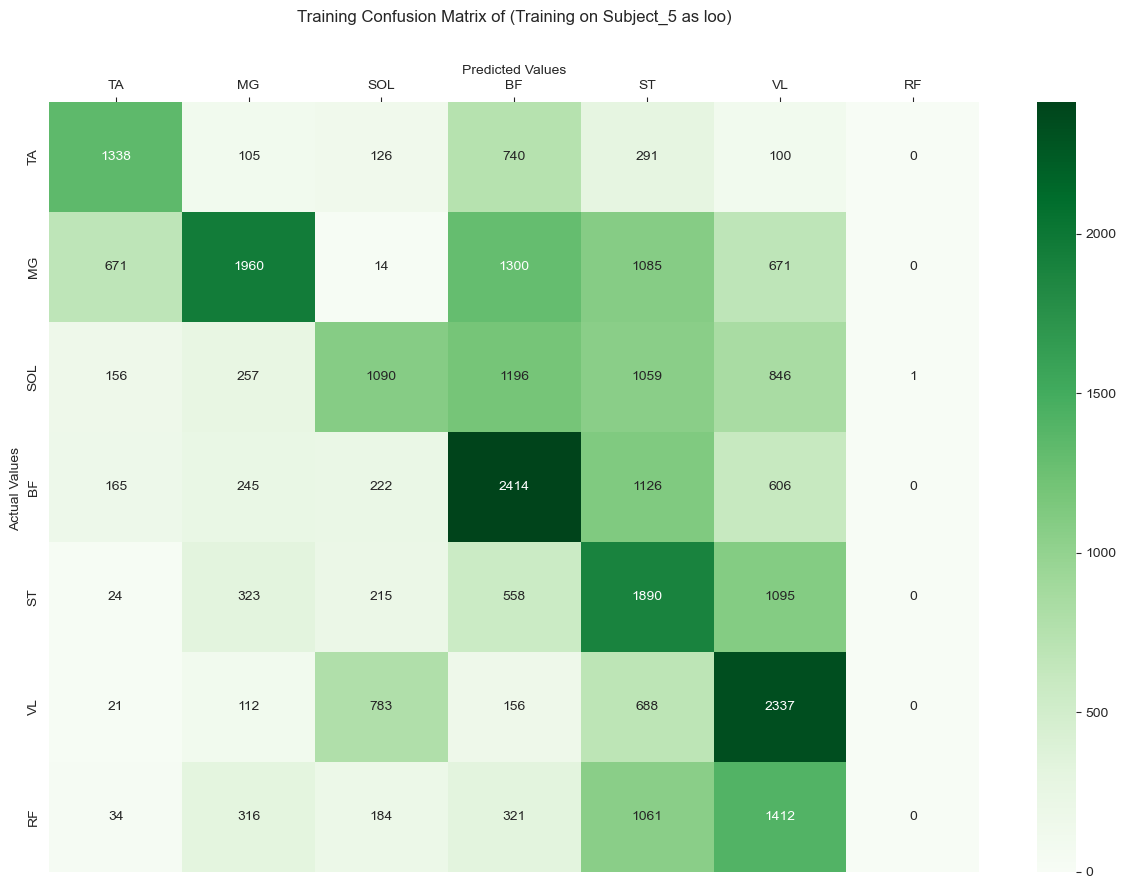

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Some y Predicted	 [5 5 5 4 4 4 4 3 3 5 2 4 3 3 2 4 5 3 2 5 1 5 4 3 2 0 5 5 2 3]
Some y Label		 [4 6 5 2 1 5 4 2 2 4 2 5 0 3 6 1 6 1 2 2 4 5 1 2 2 0 2 1 2 2]
precision: [0.67  0.543 0.413 0.122 0.31  0.327 0.   ]
recall: [0.417 0.271 0.181 0.447 0.448 0.562 0.   ]
fscore: [0.514 0.362 0.252 0.192 0.367 0.413 0.   ]
fscore_micro: 0.336


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


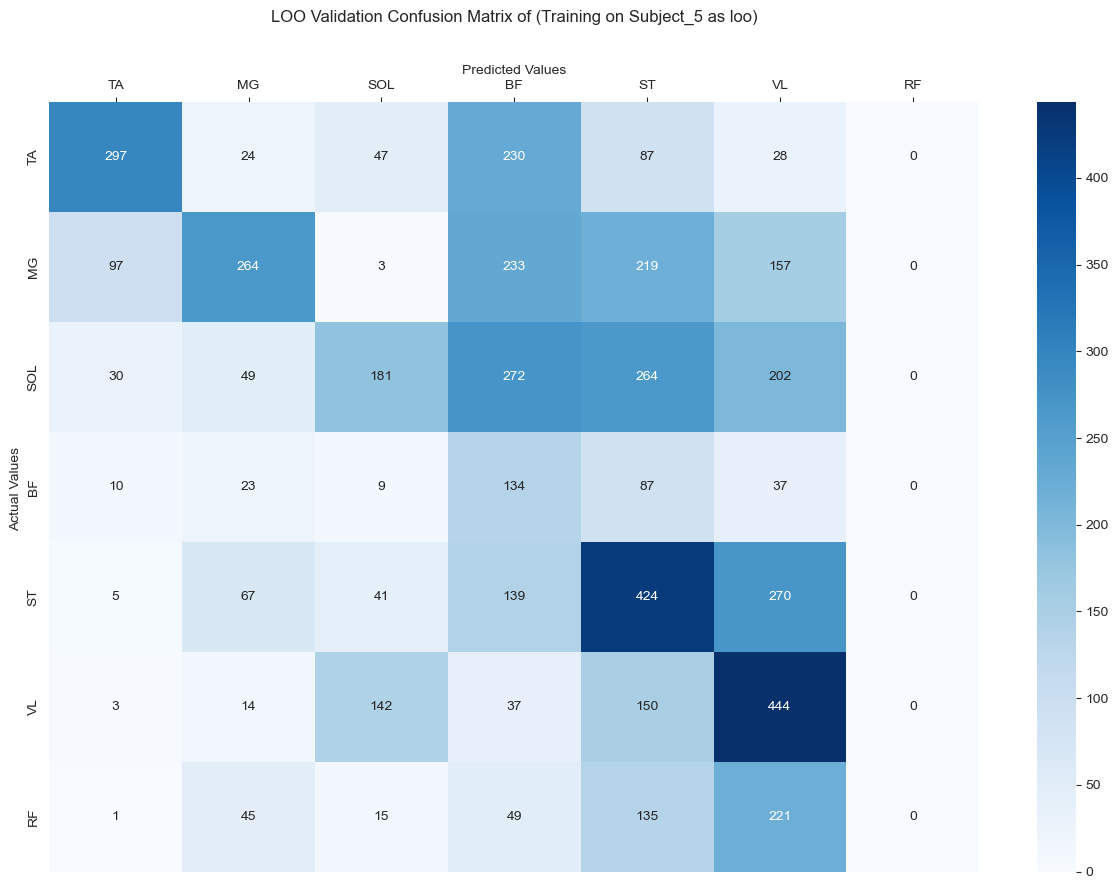

Training with subject6 as a validation set
Epoch 1/5
     35/Unknown 11s 297ms/step - accuracy: 0.4395 - loss: 1.3844

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.4382 - loss: 1.3864 - val_accuracy: 0.3760 - val_loss: 1.2520 - learning_rate: 0.0100
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.4334 - loss: 1.4058 - val_accuracy: 0.3852 - val_loss: 1.2241 - learning_rate: 0.0100
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.4573 - loss: 1.3569 - val_accuracy: 0.3679 - val_loss: 1.2096 - learning_rate: 0.0100
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.4524 - loss: 1.3556 - val_accuracy: 0.3699 - val_loss: 1.2325 - learning_rate: 0.0100
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.4514 - loss: 1.3815 - val_accuracy: 0.3769 - val_loss: 1.2341 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_6 as loo: 38.5
Minimum Validation Loss for using Subject_6 as loo: 1.21


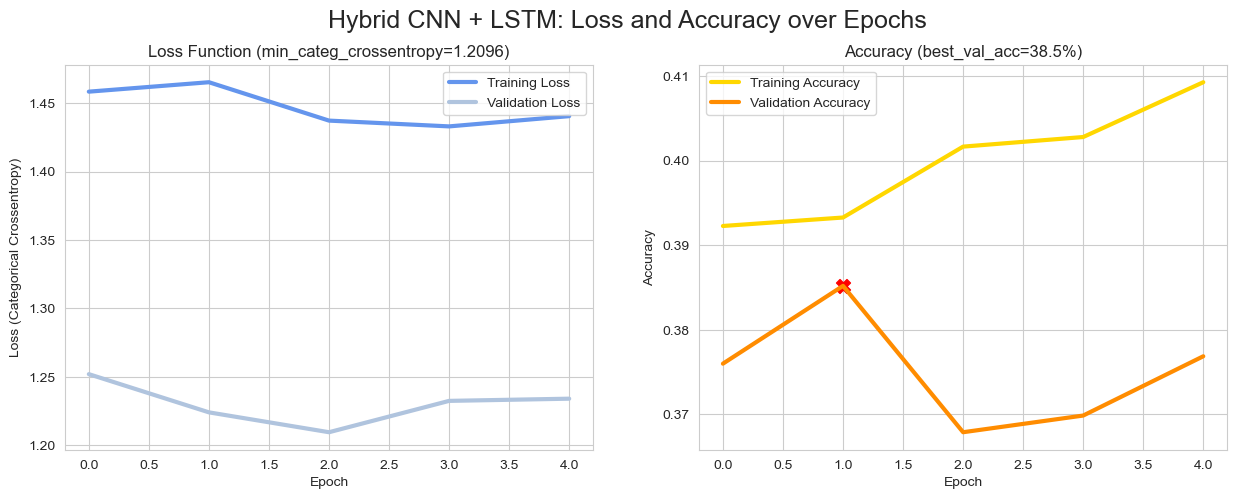

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
936/936 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [3 3 3 3 1 1 1 0 1 0 0 0 2 3 0 0 5 0 3 2 1 1 2 0 1 0 5 0 2 0]
Some y Label		 [3 3 3 3 1 1 1 6 1 3 1 1 5 3 6 0 3 0 3 3 1 1 3 3 1 0 6 1 2 1]
precision: [0.569 0.595 0.407 0.342 0.262 0.348 0.   ]
recall: [0.492 0.339 0.231 0.502 0.458 0.563 0.   ]
fscore: [0.527 0.432 0.295 0.407 0.333 0.43  0.   ]
fscore_micro: 0.377


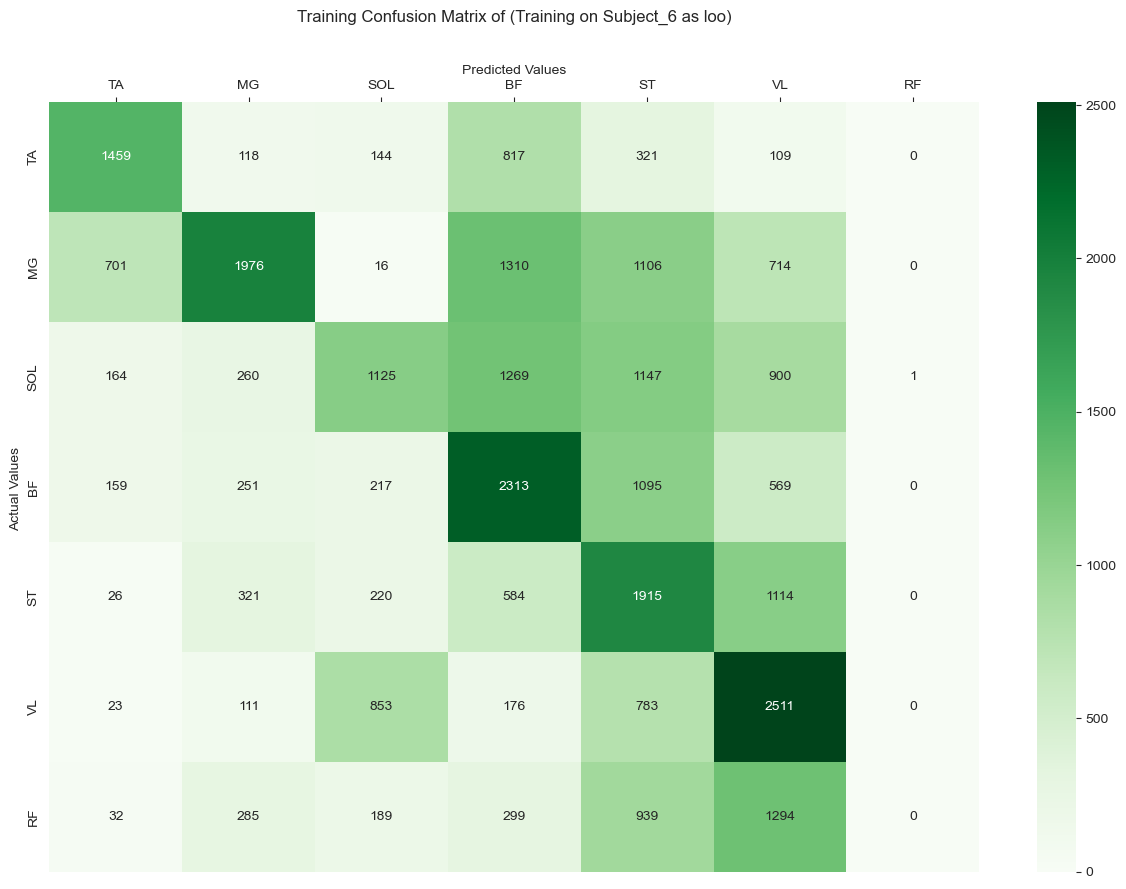

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Some y Predicted	 [5 3 5 5 4 3 4 4 1 3 2 4 4 4 3 3 3 4 5 5 0 4 5 3 3 4 4 5 5 5]
Some y Label		 [6 1 6 6 0 0 4 2 1 3 2 4 4 4 5 1 6 2 5 4 0 4 2 1 1 0 6 4 6 5]
precision: [0.611 0.515 0.474 0.232 0.317 0.222 0.   ]
recall: [0.396 0.291 0.198 0.496 0.458 0.628 0.   ]
fscore: [0.48  0.372 0.279 0.316 0.374 0.328 0.   ]
fscore_micro: 0.323


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


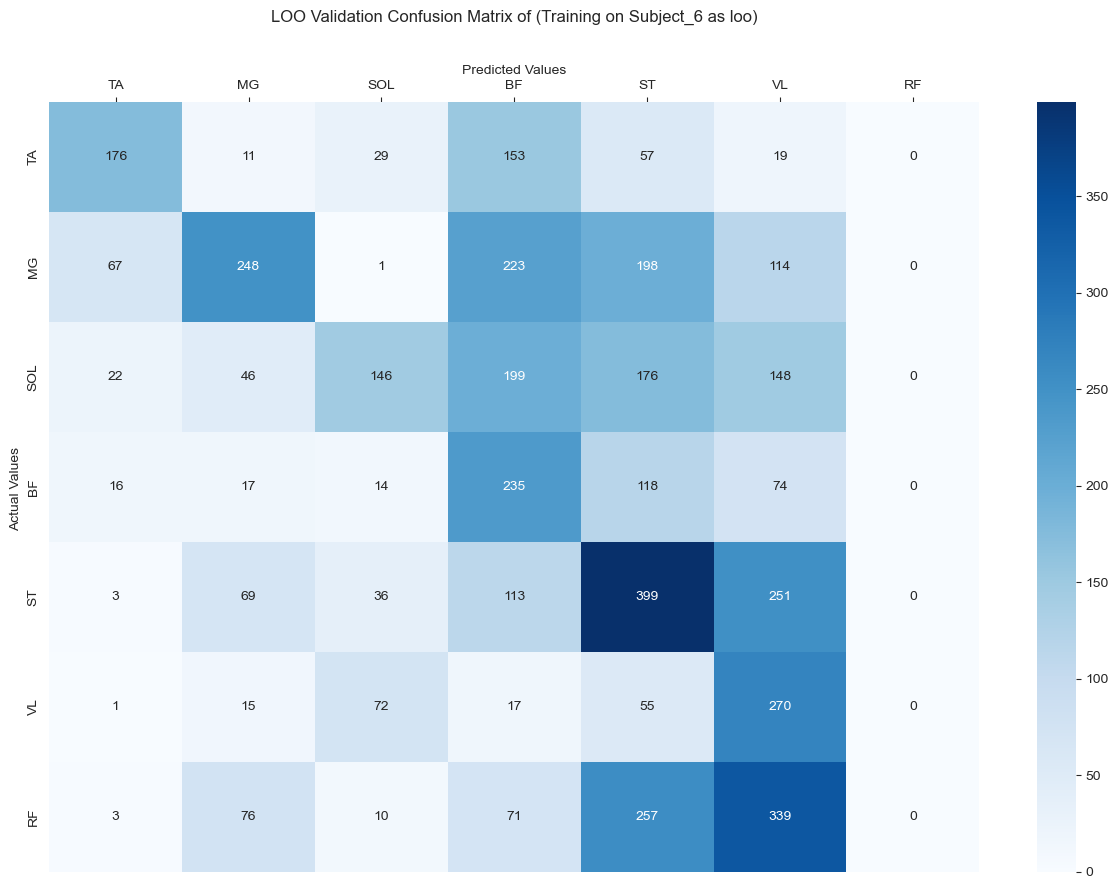

Training with subject7 as a validation set
Epoch 1/5
     36/Unknown 11s 292ms/step - accuracy: 0.4498 - loss: 1.3672

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.4485 - loss: 1.3689 - val_accuracy: 0.4594 - val_loss: 1.1225 - learning_rate: 0.0100
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.4407 - loss: 1.3870 - val_accuracy: 0.4639 - val_loss: 1.0645 - learning_rate: 0.0100
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4584 - loss: 1.3345 - val_accuracy: 0.4666 - val_loss: 1.0930 - learning_rate: 0.0100
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.4357 - loss: 1.3760 - val_accuracy: 0.4737 - val_loss: 1.1020 - learning_rate: 0.0100
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 345ms/step - accuracy: 0.4459 - loss: 1.4176 - val_accuracy: 0.4494 - val_loss: 1.1206 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_7 as loo: 47.4
Minimum Validation Loss for using Subject_7 as loo: 1.065


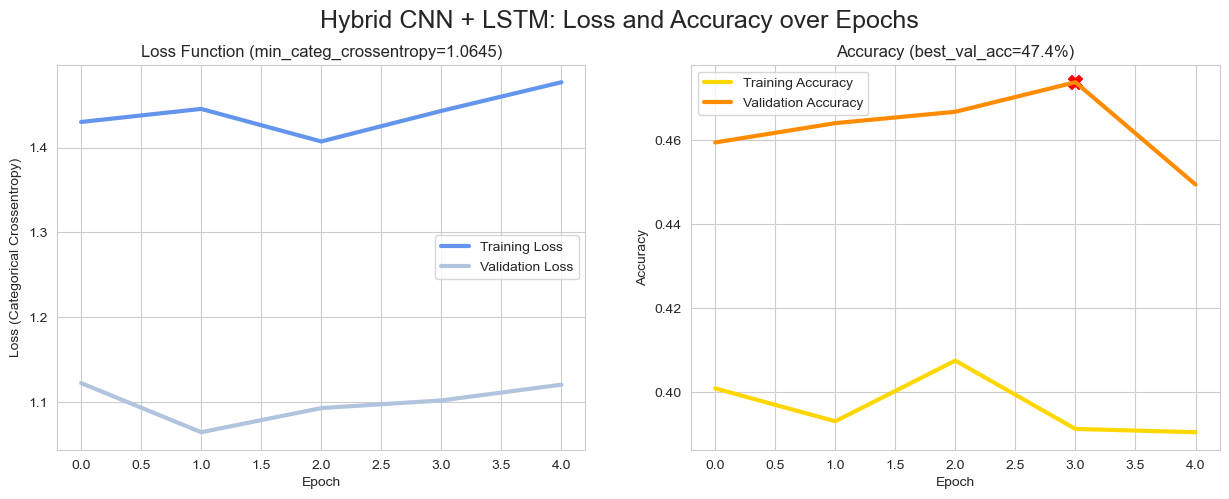

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [1 0 0 2 0 0 0 2 2 0 0 2 3 0 3 3 1 0 3 2 2 0 2 1 2 0 0 1 2 0]
Some y Label		 [1 0 0 5 0 0 0 2 6 1 1 5 3 0 3 3 1 0 3 2 3 2 3 1 5 0 1 1 5 0]
precision: [0.583 0.573 0.418 0.327 0.262 0.312 0.   ]
recall: [0.483 0.334 0.229 0.502 0.456 0.56  0.   ]
fscore: [0.528 0.422 0.296 0.396 0.333 0.4   0.   ]
fscore_micro: 0.364


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


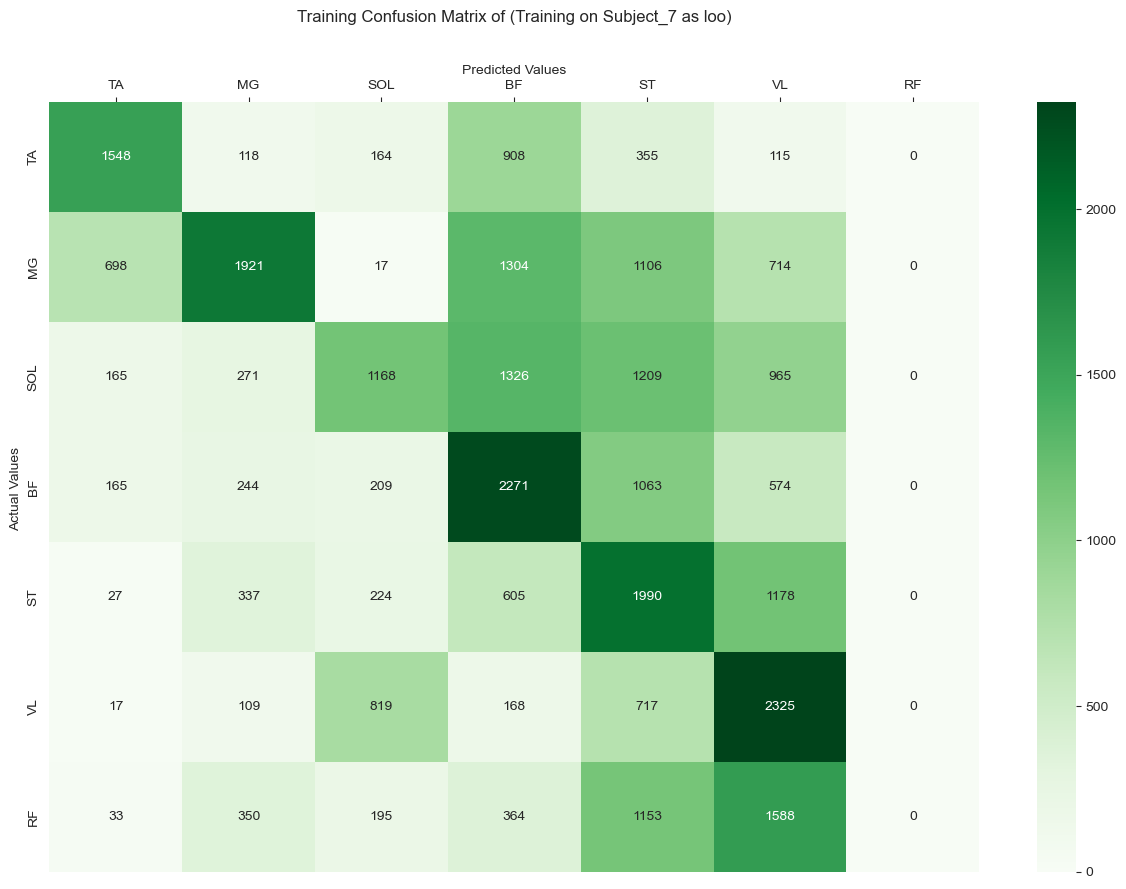

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Some y Predicted	 [5 4 2 4 5 3 1 3 2 2 5 3 5 5 4 5 2 3 3 4 0 5 4 5 3 5 5 3 5 3]
Some y Label		 [5 0 5 5 1 3 1 3 5 5 4 1 5 3 3 5 5 3 3 4 1 5 2 4 2 5 5 3 1 3]
precision: [0.437 0.667 0.373 0.333 0.333 0.472 0.   ]
recall: [0.424 0.332 0.206 0.502 0.47  0.623 0.   ]
fscore: [0.431 0.443 0.266 0.4   0.39  0.537 0.   ]
fscore_micro: 0.419


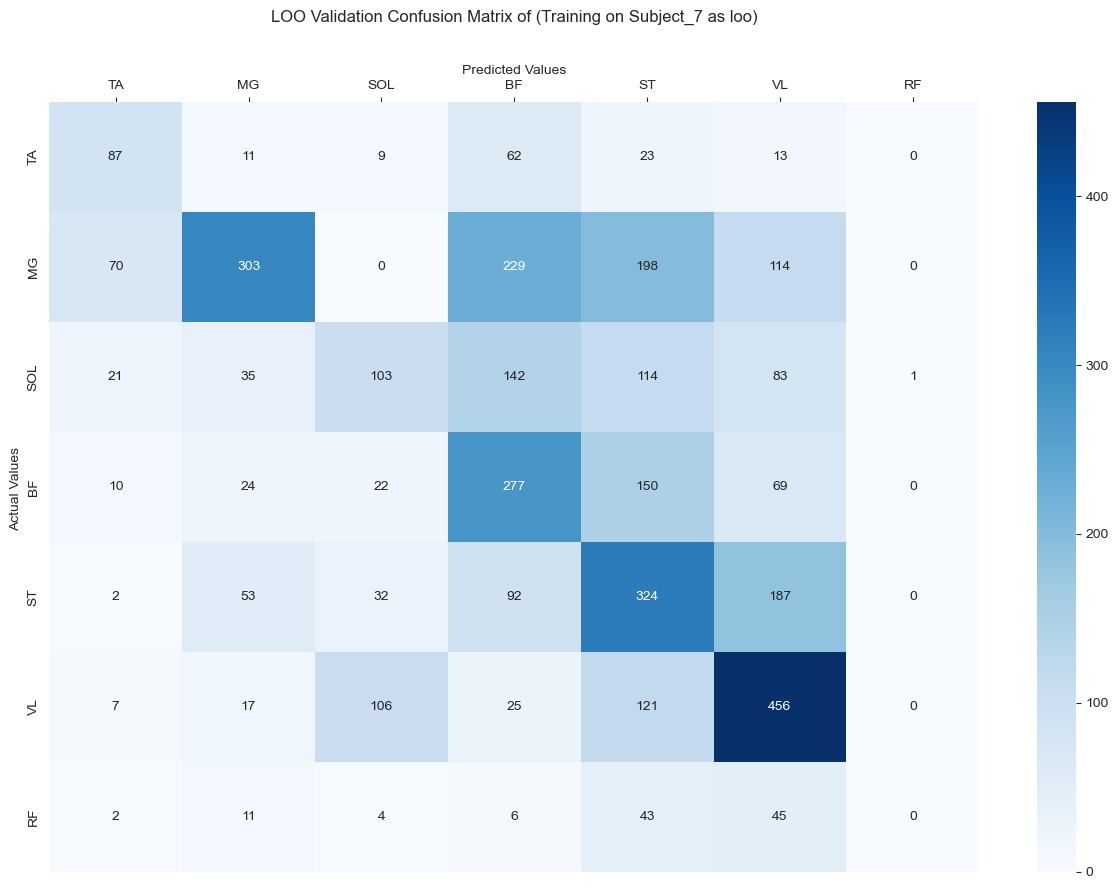

Training with subject8 as a validation set
Epoch 1/5
     36/Unknown 12s 330ms/step - accuracy: 0.4429 - loss: 1.4104

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 345ms/step - accuracy: 0.4415 - loss: 1.4117 - val_accuracy: 0.3741 - val_loss: 1.1929 - learning_rate: 0.0100
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.4507 - loss: 1.3652 - val_accuracy: 0.3869 - val_loss: 1.1640 - learning_rate: 0.0100
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step - accuracy: 0.4570 - loss: 1.3477 - val_accuracy: 0.3898 - val_loss: 1.1700 - learning_rate: 0.0100
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.4667 - loss: 1.3479 - val_accuracy: 0.3906 - val_loss: 1.1530 - learning_rate: 0.0100
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 374ms/step - accuracy: 0.4515 - loss: 1.3681 - val_accuracy: 0.3941 - val_loss: 1.1831 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_8 as loo: 39.4
Minimum Validation Loss for using Subject_8 as loo: 1.153


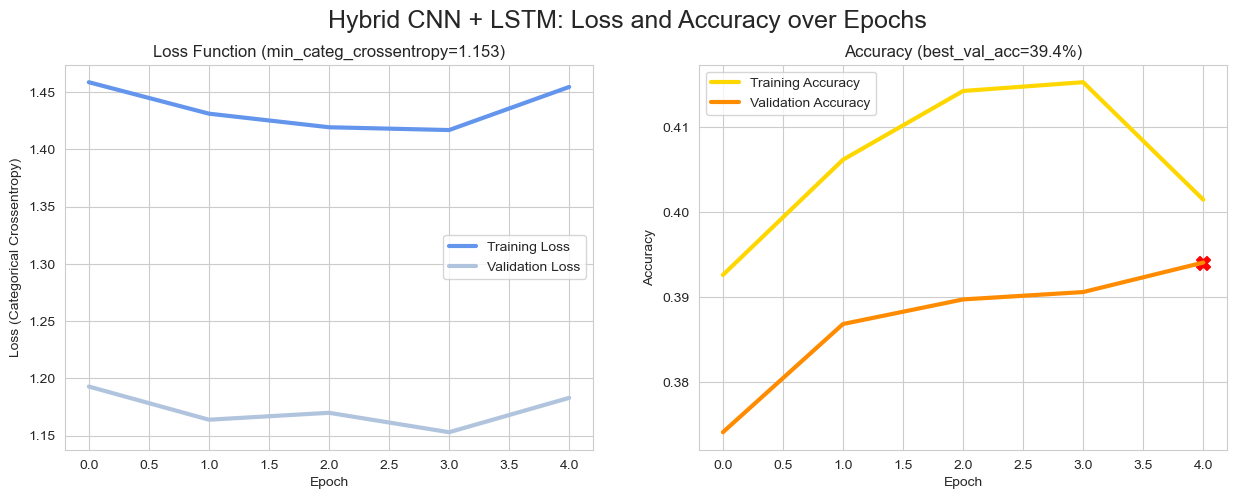

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
971/971 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [1 2 1 2 3 0 0 2 1 2 5 0 0 3 0 2 0 2 0 1 2 0 2 3 0 2 2 2 0 2]
Some y Label		 [1 2 1 2 3 1 0 2 1 2 4 1 0 3 5 5 3 3 0 1 2 0 5 3 0 3 4 2 1 5]
precision: [0.587 0.593 0.4   0.327 0.272 0.348 0.   ]
recall: [0.482 0.335 0.233 0.511 0.46  0.568 0.   ]
fscore: [0.53  0.428 0.294 0.398 0.342 0.432 0.   ]
fscore_micro: 0.377


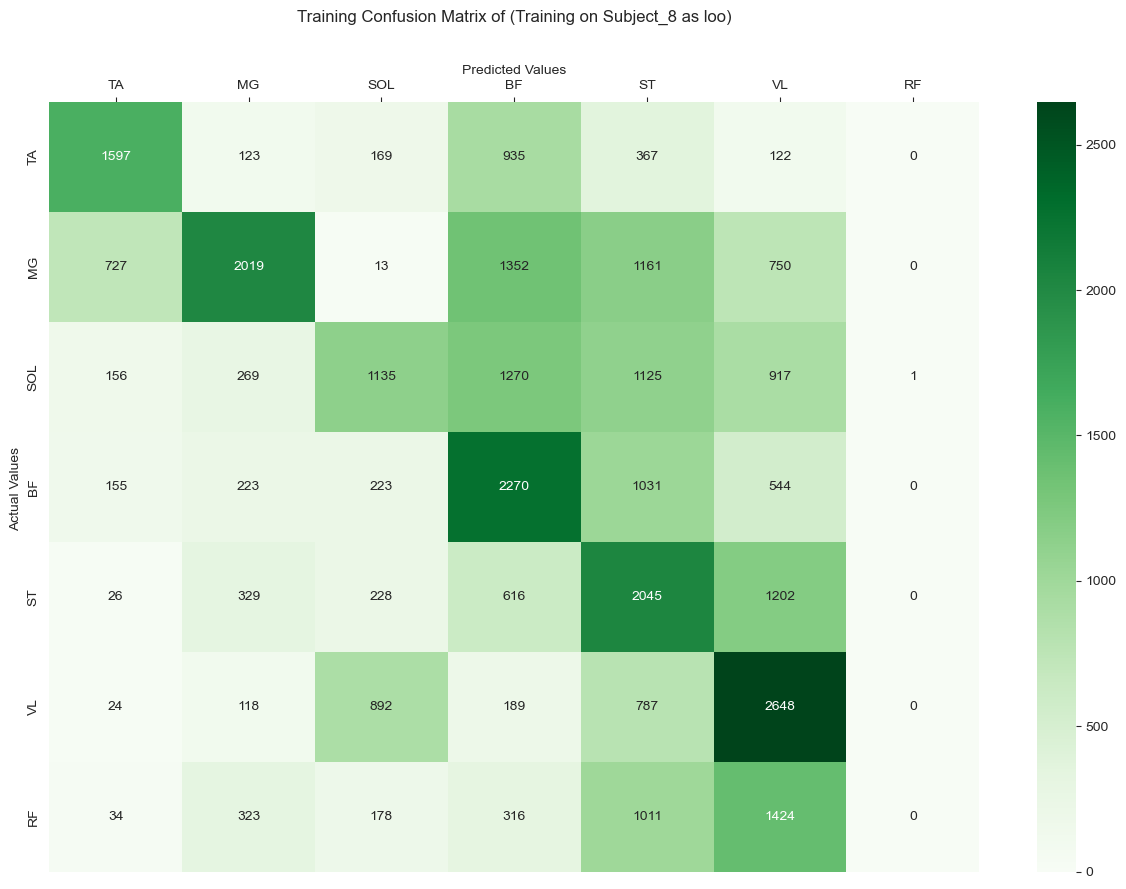

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Some y Predicted	 [4 2 1 4 3 5 2 4 4 4 4 4 5 3 4 4 4 3 1 0 5 4 4 4 1 5 0 4 3 4]
Some y Label		 [3 5 1 1 3 2 2 2 6 0 1 4 5 6 2 4 3 2 6 1 4 4 3 1 1 3 2 6 3 6]
precision: [0.286 0.512 0.581 0.335 0.259 0.162 0.   ]
recall: [0.38  0.314 0.186 0.44  0.445 0.581 0.   ]
fscore: [0.326 0.39  0.282 0.38  0.327 0.254 0.   ]
fscore_micro: 0.306


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


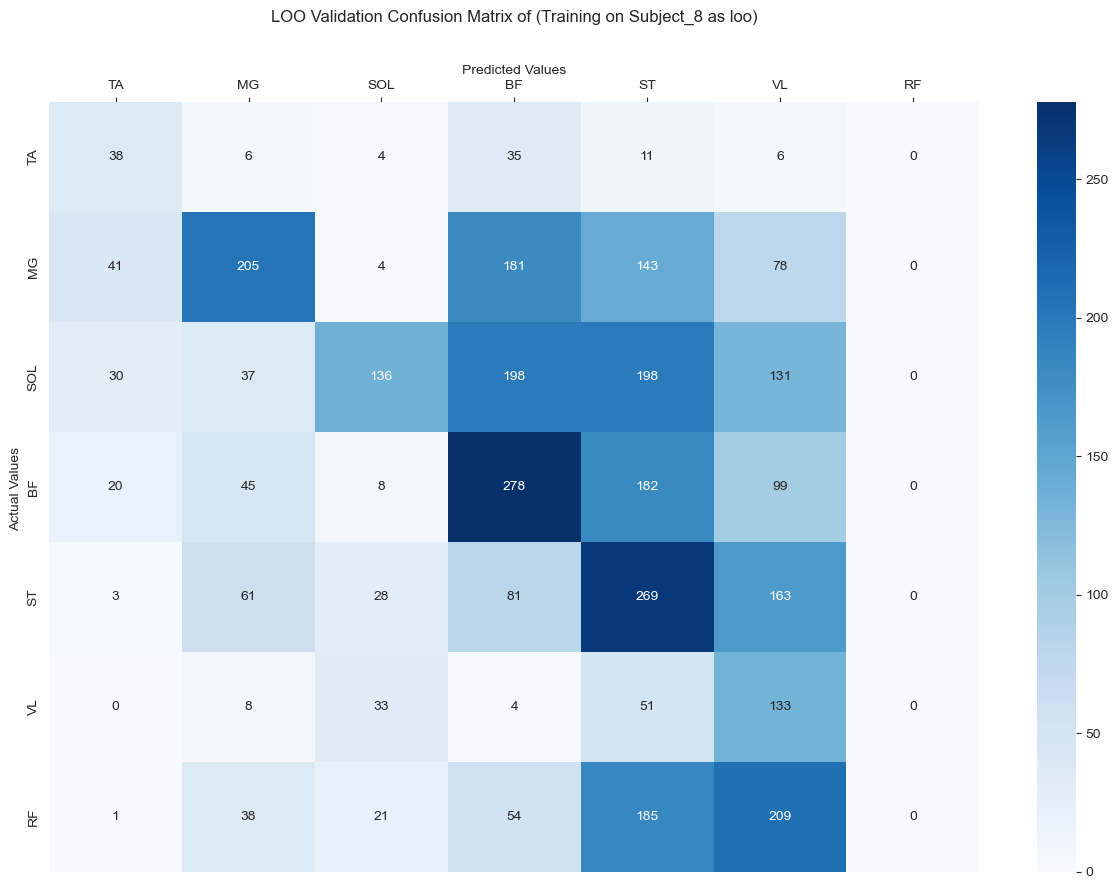

Training with subject9 as a validation set
Epoch 1/5
     38/Unknown 13s 331ms/step - accuracy: 0.4426 - loss: 1.3653

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.4417 - loss: 1.3668 - val_accuracy: 0.3638 - val_loss: 1.0748 - learning_rate: 0.0100
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.4447 - loss: 1.3474 - val_accuracy: 0.3333 - val_loss: 1.0691 - learning_rate: 0.0100
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.4548 - loss: 1.3526 - val_accuracy: 0.3056 - val_loss: 1.0443 - learning_rate: 0.0100
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.4637 - loss: 1.3302 - val_accuracy: 0.2946 - val_loss: 1.0296 - learning_rate: 0.0100
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.4671 - loss: 1.3196 - val_accuracy: 0.2382 - val_loss: 1.0661 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_9 as loo: 36.4
Minimum Validation Loss for using Subject_9 as loo: 1.03


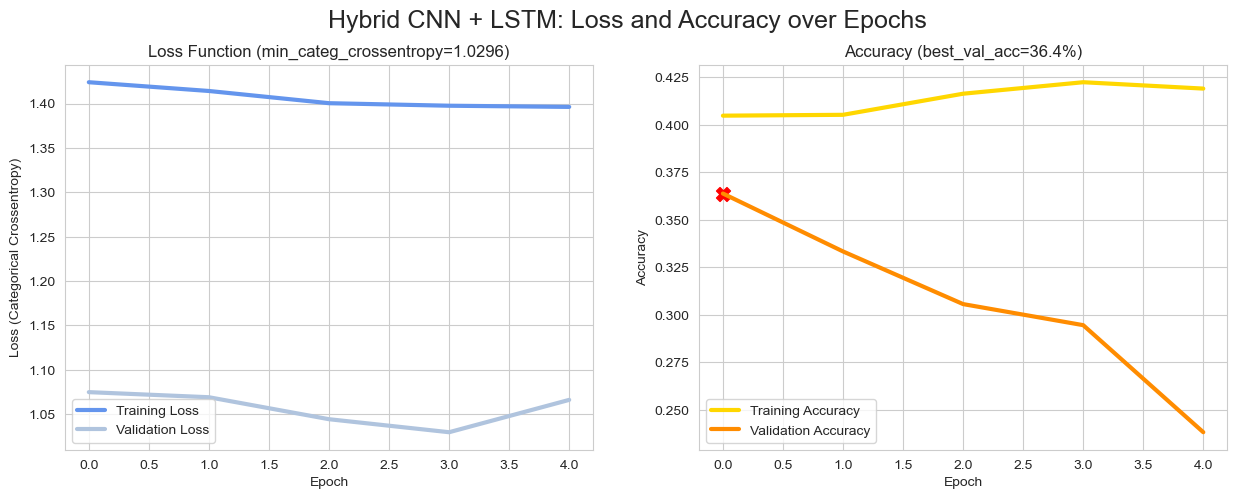

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [2 0 1 1 1 3 2 0 0 2 2 5 3 0 2 0 2 1 5 3 1 1 1 3 2 3 0 0 3 3]
Some y Label		 [5 1 1 1 1 3 2 0 0 3 6 6 3 0 2 1 5 1 5 3 1 1 1 3 2 3 0 0 3 3]
precision: [0.555 0.593 0.425 0.335 0.259 0.323 0.   ]
recall: [0.487 0.333 0.227 0.502 0.459 0.567 0.   ]
fscore: [0.519 0.427 0.296 0.402 0.332 0.411 0.   ]
fscore_micro: 0.368


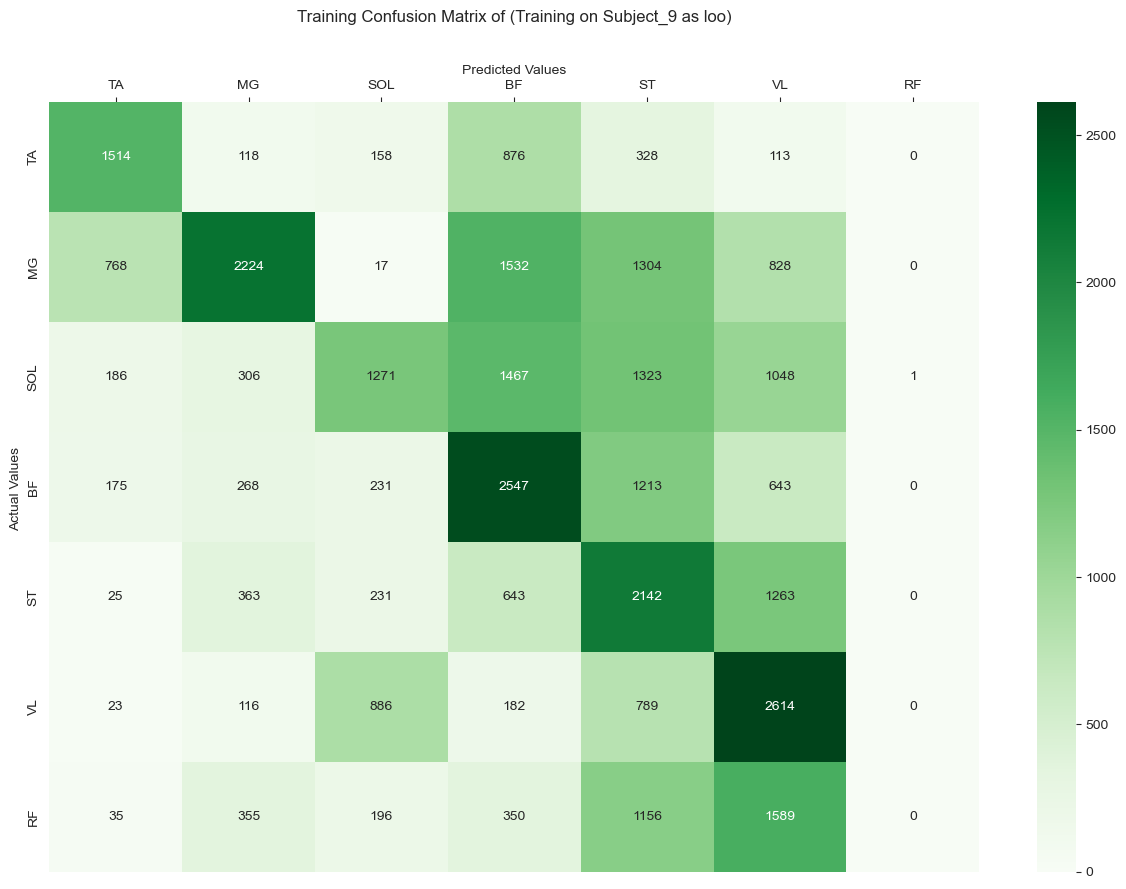

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Some y Predicted	 [3 5 3 0 4 5 3 4 5 0 0 3 4 4 5 3 0 0 3 4 4 5 2 1 3 3 4 4 2 4]
Some y Label		 [0 5 0 0 4 4 0 4 5 0 0 0 6 0 5 6 0 0 0 4 4 5 5 5 5 0 4 4 0 4]
precision: [0.96  0.    0.    0.005 0.553 0.509 0.   ]
recall: [0.395 0.    0.    1.    0.448 0.603 0.   ]
fscore: [0.56  0.    0.    0.011 0.495 0.552 0.   ]
fscore_micro: 0.426


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


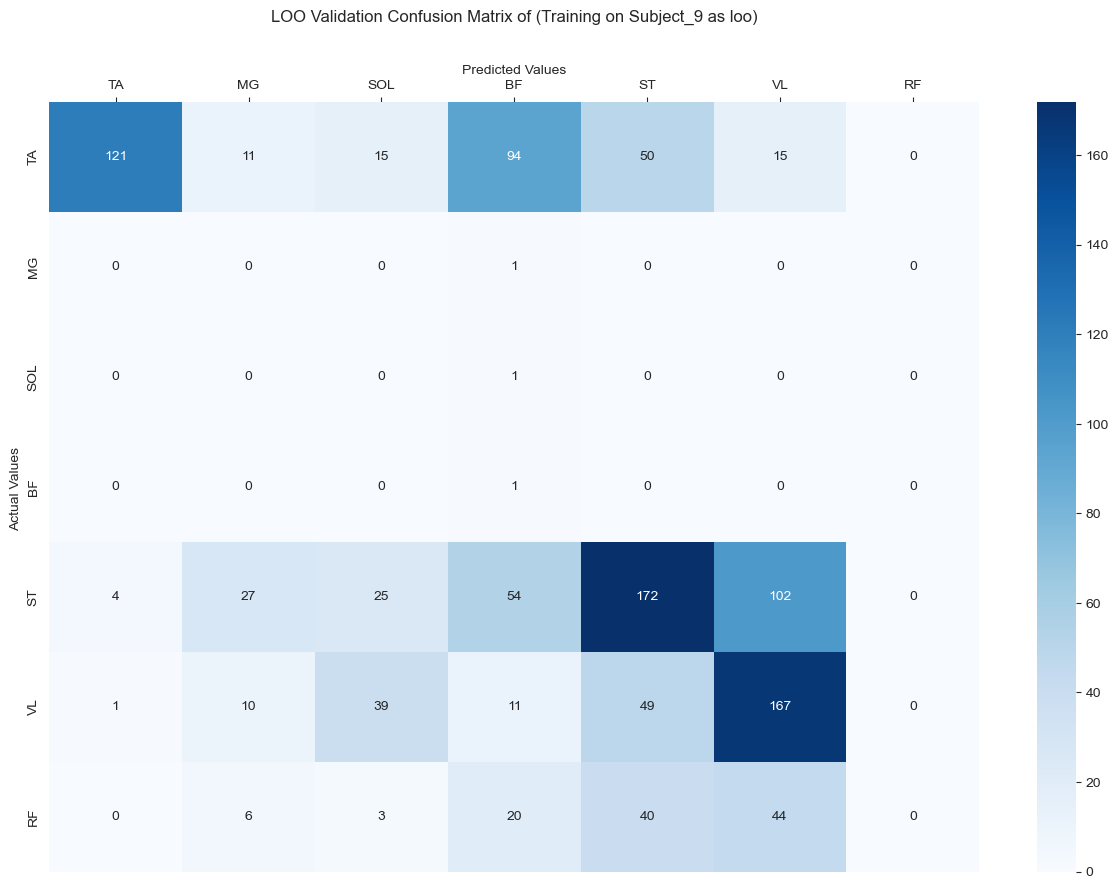

Training with subject10 as a validation set
Epoch 1/5
     35/Unknown 11s 318ms/step - accuracy: 0.4677 - loss: 1.3297

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.4649 - loss: 1.3343 - val_accuracy: 0.4365 - val_loss: 1.1835 - learning_rate: 0.0100
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.4688 - loss: 1.3157 - val_accuracy: 0.3966 - val_loss: 1.2135 - learning_rate: 0.0100
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.4525 - loss: 1.3236 - val_accuracy: 0.3768 - val_loss: 1.2289 - learning_rate: 0.0100
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 534ms/step - accuracy: 0.4413 - loss: 1.3337 - val_accuracy: 0.4137 - val_loss: 1.2113 - learning_rate: 0.0100
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 485ms/step - accuracy: 0.4604 - loss: 1.2920 - val_accuracy: 0.4125 - val_loss: 1.2065 - learning_rate: 0.0100
Best Validation Accuracy for using Subject_10 as loo: 43.6
Minimum Validation Loss for using Subject_10 as loo: 1.184


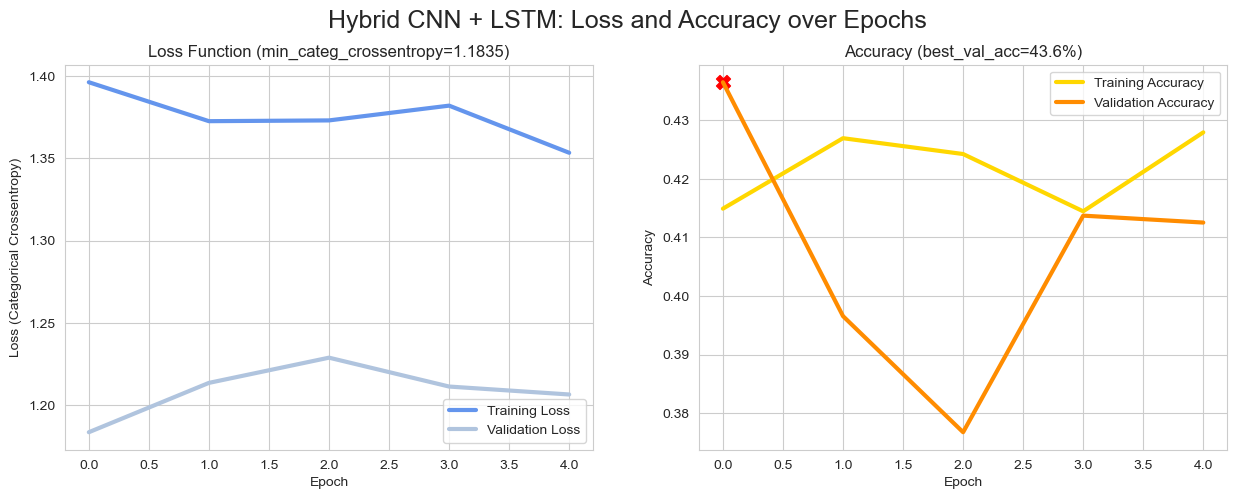

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
973/973 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Some y Predicted	 [5 0 1 2 0 1 0 3 1 2 2 3 1 1 3 0 2 3 2 0 0 0 0 0 2 1 2 0 0 2]
Some y Label		 [6 0 1 5 3 1 0 3 1 6 3 3 1 1 3 0 3 4 3 0 1 0 0 2 6 1 5 1 1 2]
precision: [0.583 0.587 0.406 0.316 0.295 0.333 0.   ]
recall: [0.488 0.344 0.233 0.524 0.458 0.572 0.   ]
fscore: [0.531 0.434 0.296 0.394 0.359 0.421 0.   ]
fscore_micro: 0.375


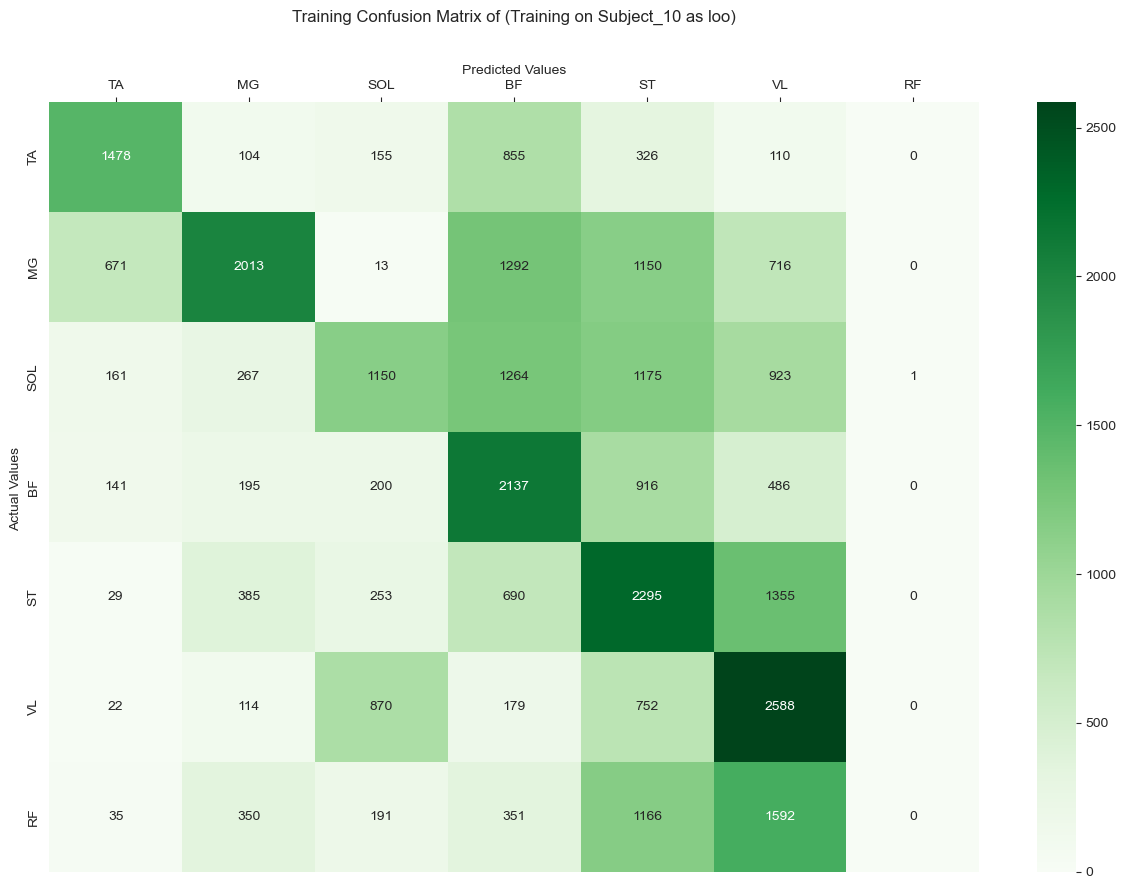

Best Model: model1\best_model_epoch_05_val_acc_0.3718.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Some y Predicted	 [1 3 5 3 0 5 3 4 3 4 3 3 4 1 1 4 1 2 0 4 1 3 3 2 4 0 0 4 3 4]
Some y Label		 [3 2 1 3 1 3 3 2 3 5 2 3 2 1 1 6 3 2 1 0 1 3 1 5 5 0 0 3 2 2]
precision: [0.498 0.561 0.504 0.407 0.024 0.294 0.   ]
recall: [0.408 0.258 0.183 0.41  0.432 0.533 0.   ]
fscore: [0.449 0.353 0.268 0.408 0.046 0.379 0.   ]
fscore_micro: 0.329


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


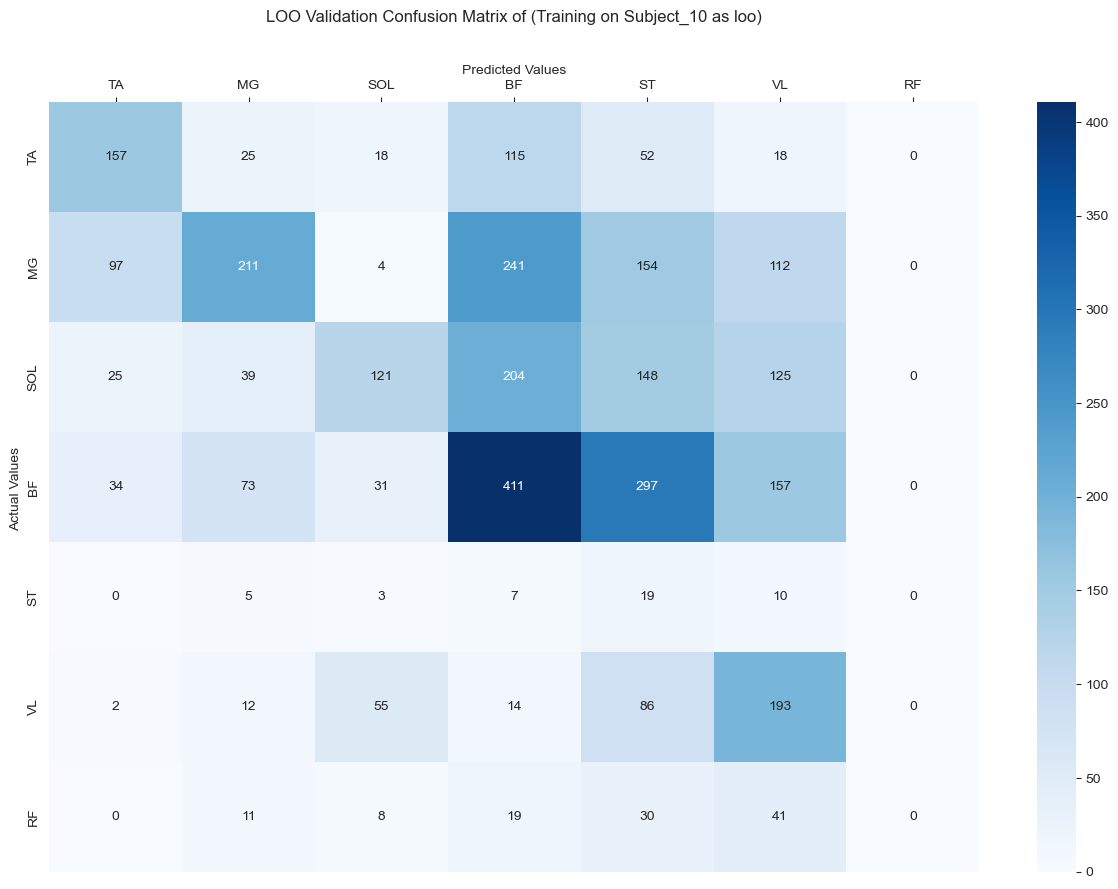

In [59]:
# LOSOCV Training Loop
for loo_subject in range(num_subjects):  # Change range to start from 0 to num_subjects-1
	print(f"Training with subject{loo_subject + 1} as a validation set") 

	# Prepare training and validation datasets
	loo_valid_dataset = all_subjects_loo_data[loo_subject]
	loo_train_datasets = [d for i, d in enumerate(all_subjects_loo_data) if i != loo_subject]
    # Correctly concatenate datasets
	train_dataset = reduce(tf.data.Dataset.concatenate, loo_train_datasets)
	# train_dataset = tf.data.Dataset.concatenate(*loo_train_datasets)

	# Define checkpoint path correctly with adjusted loo_subject index
	cp = ModelCheckpoint(
		f'model1/best_model_subj_{loo_subject + 1}_{{epoch:02d}}_val_acc_{{val_accuracy:.4f}}.keras',
		save_best_only=True, monitor='val_accuracy', mode='max')

	# Train the model with the correct validation dataset
	try:
		history = model1.fit(train_dataset, validation_data=loo_valid_dataset,
		                     epochs=wandb.config.epochs, callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])
	except Exception as e:
		print(f"Error training model with subject_{loo_subject + 1} as LOO: {str(e)}")
		continue  # Skip to the next iteration

	# Log the best validation accuracy and loss for each subject
	best_val_accuracy = round(max(history.history['val_accuracy']),3)*100
	min_val_loss = round(min(history.history['val_loss']), 3)
	print(f"Best Validation Accuracy for using Subject_{loo_subject+1} as loo: {best_val_accuracy}")
	print(f"Minimum Validation Loss for using Subject_{loo_subject+1} as loo: {min_val_loss}")
	best_loo_validation_per_subject.append(best_val_accuracy)
	min_loo_val_loss_per_subject.append(min_val_loss)

	# Saving history
	history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_loss})_loo_subject {loo_subject+1}'
	np.save(history_name + '.npy',history.history)

	## Plotting Loss and Accuracy Metrics over Epochs
	plotting_loss_and_accuracy_over_epochs(history_name, loo_subject+1)

	## Serializing Datasets (train and val)
	x_train, y_train, x_val, y_val = serializing_datasets(train_dataset,loo_valid_dataset)

	## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
	## Confusion Matrix in Training
	plot_confusion_matrix(x_train, y_train, 'Greens', f'Training Confusion Matrix of (Training on Subject_{loo_subject+1} as loo)')
	## Confusion Matrix in Testing
	interpersonal_precision, interpersonal_recall, interpersonal_f1, interpersonal_f1_micro  =\
		plot_confusion_matrix(x_val, y_val, 'Blues', f'LOO Validation Confusion Matrix of (Training on Subject_{loo_subject+1} as loo)')
	
	all_interpersonal_precision.append(interpersonal_precision)
	all_interpersonal_recall.append(interpersonal_recall)
	all_interpersonal_f1.append(interpersonal_f1)
	all_interpersonal_f1_micro.append(interpersonal_f1_micro)

In [60]:
# Log the best validation accuracy and loss
wandb.log({"interpersonal_mean_accu":  np.mean(best_loo_validation_per_subject),
           "interpersonal_mean_val_loss": np.mean(min_loo_val_loss_per_subject),
           "interpersonal_mean_precision": np.mean(all_interpersonal_precision),
           "interpersonal_mean_recall": np.mean(all_interpersonal_recall),
           "interpersonal_mean_f1": np.mean(all_interpersonal_f1),
           "interpersonal_mean_f1_micro": np.mean(all_interpersonal_f1_micro)})
wandb.finish()

batch/accuracy,▁▁▂▃▃▂▂▄▃▄▄▄▅▄▃▄▄▄█▄▄▄▄▅▆▆▅▄▆▄▄▆▆▄▆▆▅▅▅▅
batch/batch_step,▁▃▅▁▃▅▇▂▃▅▇▃▅▆▂▄▆█▂▄▆▂▃▅▁▂▅▆▁▃▅▇▁▃▅▇▂▃▅█
batch/loss,██▇▆▆▆▇▆▆▆▅▅▄▅▆▆▅▅▁▅▅▅▅▄▃▃▄▅▄▅▄▃▃▄▂▂▄▄▃▄
best_val_accuracy,▁
epoch/accuracy,▁▁▂▅▄▄▅▅▅▅▅▆▆▆▆▅▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇██████
epoch/epoch,▁▃▅█▁▃▆█▃▅▆▁▃▆█▁▅▆█▃▅█▁▃▆█▃▅▆▁▃▅█▁▅▆█▃▅█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▄▅▅▅▅▅▄▄▄▃▄▄▄▄▃▃▃▃▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▁▂▃█▇▇█▂▂▂▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▃▃▃▃▃▂▂▁▃▃▄
epoch/val_loss,███▆▁▃▁▁▇▇▇▆▇▇▇▂▂▂▂▆▆▅▅▅▅▅▄▄▄▅▅▅▅▄▄▄▄▅▅▅
interpersonal_mean_accu,▁


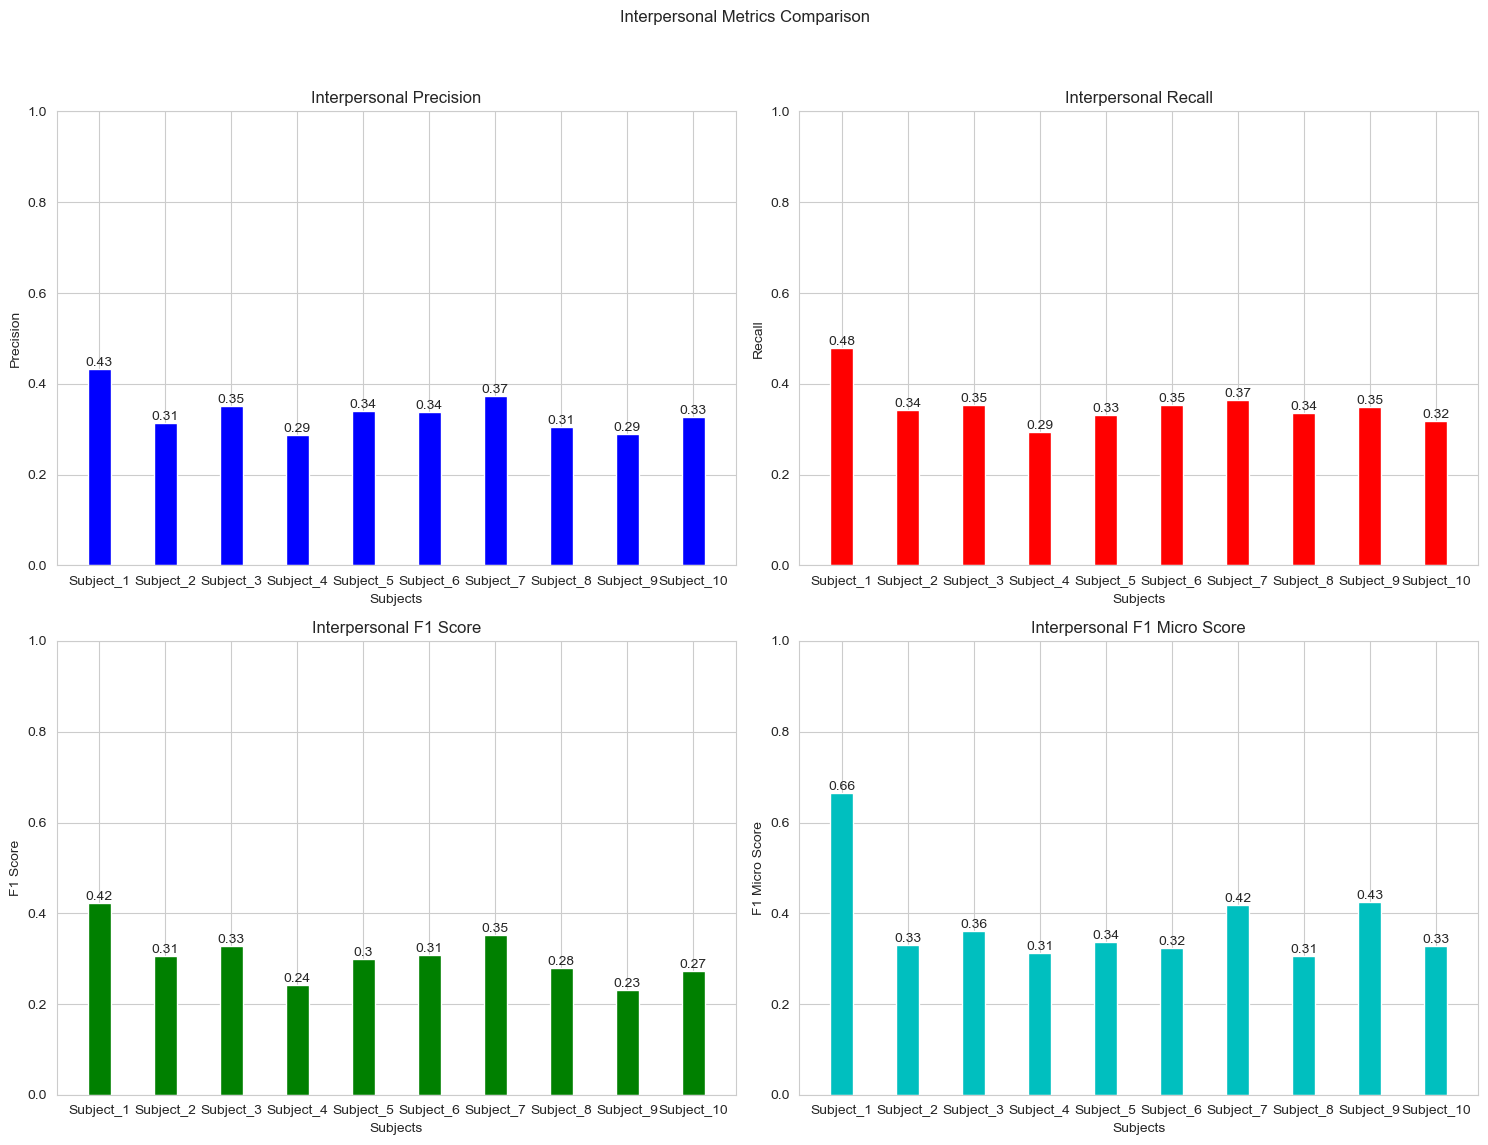

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1, all_interpersonal_f1_micro):
    subjects = [f"Subject_{i+1}" for i in range(len(all_interpersonal_precision))]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the figure size as necessary
    fig.suptitle('Interpersonal Metrics Comparison')

    # Setting the width of the bars
    bar_width = 0.35

    # Helper function to add value labels on top of bars
    def add_value_labels(ax):
        for i in ax.patches:
            ax.text(i.get_x() + i.get_width() / 2, i.get_height(), 
                    round(i.get_height(), 2), ha = 'center', va = 'bottom')

    # Plotting Precision
    axs[0, 0].bar(subjects, all_interpersonal_precision, color='b', width=bar_width)
    axs[0, 0].set_title('Interpersonal Precision')
    axs[0, 0].set_xlabel('Subjects')
    axs[0, 0].set_ylabel('Precision')
    axs[0, 0].set_ylim([0, 1])  # Adjust y-axis limits if needed
    add_value_labels(axs[0, 0])

    # Plotting Recall
    axs[0, 1].bar(subjects, all_interpersonal_recall, color='r', width=bar_width)
    axs[0, 1].set_title('Interpersonal Recall')
    axs[0, 1].set_xlabel('Subjects')
    axs[0, 1].set_ylabel('Recall')
    axs[0, 1].set_ylim([0, 1])
    add_value_labels(axs[0, 1])

    # Plotting F1 Score
    axs[1, 0].bar(subjects, all_interpersonal_f1, color='g', width=bar_width)
    axs[1, 0].set_title('Interpersonal F1 Score')
    axs[1, 0].set_xlabel('Subjects')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].set_ylim([0, 1])
    add_value_labels(axs[1, 0])

    # Plotting Micro F1 Score
    axs[1, 1].bar(subjects, all_interpersonal_f1_micro, color='c', width=bar_width)
    axs[1, 1].set_title('Interpersonal F1 Micro Score')
    axs[1, 1].set_xlabel('Subjects')
    axs[1, 1].set_ylabel('F1 Micro Score')
    axs[1, 1].set_ylim([0, 1])
    add_value_labels(axs[1, 1])

    # Improve layout to prevent labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def ensure_single_value(metrics):
    # Ensuring each metric is a single value by averaging if necessary
    if metrics.ndim > 1:  # checks if the metrics array is multi-dimensional
        metrics = np.mean(metrics, axis=1)  # taking mean over the second dimension
    return metrics

# Apply the fix before plotting
all_interpersonal_precision = ensure_single_value(np.array(all_interpersonal_precision))
all_interpersonal_recall = ensure_single_value(np.array(all_interpersonal_recall))
all_interpersonal_f1 = ensure_single_value(np.array(all_interpersonal_f1))
all_interpersonal_f1_micro = ensure_single_value(np.array(all_interpersonal_f1_micro))

# Now plot the data
plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1, all_interpersonal_f1_micro)

# TODO : - 
#  - thabbet elli el modele 9a3ed yet3awed freshk koll marra!!!!!! mich el nafs el weights elli deja raw el subjects fil 20/80 !!!! 
#  - verify elli reellement lezem nrenih ala fazet el 20 80%  ????
#  - al9a 7all l kifech naamel wandb logging bil s7i7 lil losocv  ?????
#  - 7ell el mochkel taa el text elli mich 9a3ed yodhher bil s7i7 w les graphes elli yet3awdou koll marra, kizebi. 
#  - adapti el architecture hedhi l azber achritec 3maltha fil notebook le5er !!!!!! 
#  - merge both notebooks! 
